# Testing degradation on ABC vs true distribution

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

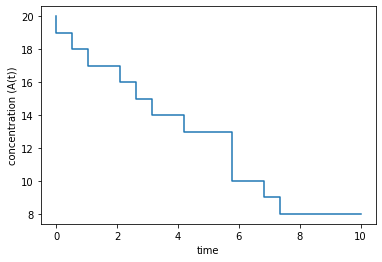

In [3]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [4]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


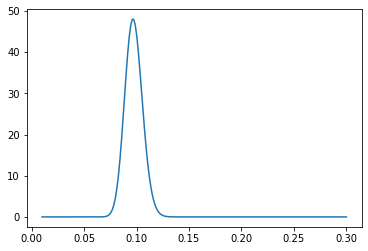

In [5]:
plt.plot(thetas, true_prob)
plt.show()

# Rejection ABC

In [5]:
np.random.seed(0)

abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(0.7)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1046   0.000956022945   0:00.5
2     1397   0.00143163923    0:00.7
3     2614   0.00114766641    0:01.2
20    19895  0.00100527771    0:07.9
40    42877  0.000932901089   0:16.9
60    73388  0.000817572355   0:28.9
80    97241  0.000822698245   0:38.5
100   110681  0.000903497439   0:43.8
120   132558  0.000905264111   0:52.3
140   158391  0.000883888605   1:02.3
160   178814  0.000894784525   1:10.2
180   211164  0.000852418026   1:22.7
200   237387  0.000842506119   1:32.8
220   262436  0.000838299624   1:43.1
240   285525  0.000840556869   1:52.1
260   321198  0.000809469548   2:05.8
280   348160  0.000804227941   2:16.1
300   379124  0.000791297834   2:28.2
320   406451  0.000787302775   2:38.8
340   430202  0.000790326405   2:48.4
360   461336  0.00078034231    3:00.4
380   491470  0.000773190632   3:12.1
400   507176  0.000788680852   3:18.2
420   535997  0.000783586475   3:29.3

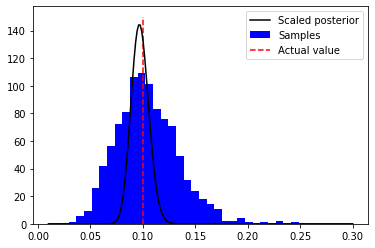

In [6]:
plt.hist(samples[:,0], 30, color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
mod_true_prob = [x * 3 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

# Compute Kernel Density Estimate

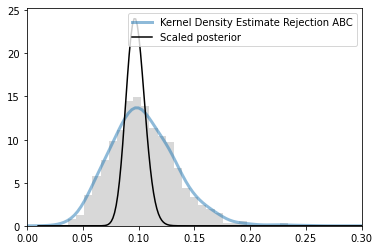

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for y in samples[:, 0] for x in y])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Save samples 

In [67]:
rej_abc_samples = samples

transf_samples = [x for y in samples[:, 0] for x in y]

print(transf_samples)

[0.08236422720534019, 0.10178792705852524, 0.14862222267015268, 0.12535874076487727, 0.1282667539522229, 0.12802938185552537, 0.13280479677759602, 0.11135752309729809, 0.10874753703947798, 0.1119494050662071, 0.12563008402922524, 0.13858492244511628, 0.09297479658263343, 0.11346175679890907, 0.09771545632863245, 0.08172476315317154, 0.0760038592284387, 0.10628029661612688, 0.09548408470473979, 0.1241595643723361, 0.05777665626257608, 0.057069730312707845, 0.10801465983137083, 0.07185434377957661, 0.14219572454720705, 0.06453438990325407, 0.09607347618995866, 0.09178225854971883, 0.16943272197104692, 0.12556987097215572, 0.09660067494396307, 0.10107166783413322, 0.08277157540697834, 0.10896963627515248, 0.09723980927858196, 0.05943635205539226, 0.12893912234451457, 0.1577562316587515, 0.08960639524698527, 0.06834083054931442, 0.07228280338227472, 0.17251222589222723, 0.12258000898510661, 0.08729846484075159, 0.09671612546686371, 0.07352804152034058, 0.11698606066076506, 0.08535337715252

In [6]:
some_str = "0.08236422720534019, 0.10178792705852524, 0.14862222267015268, 0.12535874076487727, 0.1282667539522229, 0.12802938185552537, 0.13280479677759602, 0.11135752309729809, 0.10874753703947798, 0.1119494050662071, 0.12563008402922524, 0.13858492244511628, 0.09297479658263343, 0.11346175679890907, 0.09771545632863245, 0.08172476315317154, 0.0760038592284387, 0.10628029661612688, 0.09548408470473979, 0.1241595643723361, 0.05777665626257608, 0.057069730312707845, 0.10801465983137083, 0.07185434377957661, 0.14219572454720705, 0.06453438990325407, 0.09607347618995866, 0.09178225854971883, 0.16943272197104692, 0.12556987097215572, 0.09660067494396307, 0.10107166783413322, 0.08277157540697834, 0.10896963627515248, 0.09723980927858196, 0.05943635205539226, 0.12893912234451457, 0.1577562316587515, 0.08960639524698527, 0.06834083054931442, 0.07228280338227472, 0.17251222589222723, 0.12258000898510661, 0.08729846484075159, 0.09671612546686371, 0.07352804152034058, 0.11698606066076506, 0.08535337715252439, 0.12248400516241725, 0.10268015045597216, 0.21867716898016654, 0.0885236425212834, 0.10748465814981485, 0.0819118784182684, 0.07082585500136976, 0.1689302242365553, 0.0908338863393618, 0.09275300247673728, 0.12574444024638556, 0.09693625246477211, 0.11072360066006783, 0.12204634891587055, 0.0823988137123594, 0.06578881690274471, 0.07172754788723529, 0.051155709454393426, 0.09791393249334764, 0.07663405732050756, 0.14991490651451625, 0.08882390039517792, 0.1176975061726003, 0.12310433852123592, 0.15474660210391314, 0.10088606525635115, 0.10156357567850692, 0.09873384294649264, 0.1543696152930693, 0.1511985571723616, 0.08706659908078289, 0.14114320225839036, 0.08028287195374124, 0.11602618763316955, 0.07838567269814635, 0.11770532320890825, 0.0631143294863175, 0.1287306800392842, 0.12425230379209112, 0.12392123023918633, 0.09246341617588355, 0.08665113163099586, 0.05302751963431441, 0.09490160048815022, 0.08374597542835761, 0.10392851977139642, 0.14266900764738816, 0.07912283049617212, 0.12253739550597094, 0.12266202904097451, 0.07312568011753143, 0.08439275345326179, 0.0770563883857275, 0.10813760974433897, 0.12723437852910816, 0.09092963185017848, 0.10760299624828189, 0.08747735964544899, 0.0875847297099095, 0.16109728225466038, 0.1154644071041236, 0.08576051325935816, 0.0874970239529757, 0.11003734885193742, 0.10521851610249562, 0.12572329558976292, 0.09520540191043557, 0.10164088917421785, 0.13286730514279277, 0.09089743584702646, 0.11657272497702684, 0.10732691710100158, 0.10338323511907667, 0.14381515949656584, 0.08980682208908182, 0.0937976739785164, 0.10657984507844404, 0.05034961903052678, 0.11246683278672645, 0.11463020811405988, 0.08641976424847317, 0.11959041597642975, 0.08392003100079765, 0.11723329240413449, 0.12355004568855209, 0.1566676316503259, 0.12886829189723573, 0.08519760153479224, 0.09522598142958097, 0.0963634878107327, 0.1778027579097255, 0.14490187482340336, 0.12131138077786713, 0.1159421242869928, 0.08795378142940674, 0.049955016253706276, 0.1179412330885895, 0.11239378451747724, 0.08556410432295826, 0.08836672492274267, 0.09539674930191856, 0.08360725353798844, 0.0727615200951941, 0.11055243887804819, 0.08947366344440237, 0.12206004239075481, 0.11224883748217991, 0.12330019044113233, 0.1255901280597711, 0.05922463132569961, 0.13321836887162944, 0.1471256848561897, 0.11794088897358818, 0.09955926638355757, 0.0982209214050136, 0.07428949463588186, 0.14347486275992793, 0.06259859608606623, 0.05709663939698427, 0.08202650585561735, 0.10816349829458106, 0.1670867728637714, 0.09998746139436963, 0.0691853154778957, 0.09502759755652367, 0.10974208765162917, 0.1044146891004698, 0.1454988881057013, 0.10177586741040778, 0.1183093834999201, 0.10856202267241533, 0.08628099249143349, 0.09225128648556315, 0.11733800991271875, 0.12704333475946272, 0.11521574088218722, 0.06295243613467379, 0.09915876381278371, 0.09788560469314933, 0.11271453970897898, 0.146460483075516, 0.08851730950273164, 0.10567002301662669, 0.1152063025344476, 0.0652553625343643, 0.07862347953784522, 0.0954436285645541, 0.09543790599865505, 0.09058722372444866, 0.09653685486564124, 0.08004134607579004, 0.22957823616206485, 0.06885094199265686, 0.10390535807977348, 0.08391906724612068, 0.15514834668115926, 0.1313947204446784, 0.09951439514531359, 0.13136985253190284, 0.12352774234127045, 0.07741689845826662, 0.07137717589910753, 0.13026943880015052, 0.07356765208630335, 0.1575198955847833, 0.08021242471209357, 0.10673421086111526, 0.08521395808725513, 0.055399329178514596, 0.150386809377164, 0.061778194373484016, 0.1078828849862508, 0.1341762947263137, 0.0997295002319806, 0.10171838080993802, 0.06367257757708845, 0.08760224782759973, 0.15641274803723298, 0.12447375418547046, 0.08633640109193728, 0.11487111824069954, 0.0756282936767957, 0.05777660887204558, 0.10118008879219194, 0.096501364067772, 0.03960552873227746, 0.09618372638157287, 0.11087092700295693, 0.07846972317072672, 0.11196009871550079, 0.11001201127692398, 0.10893188095719522, 0.09038792844918411, 0.07943462239780597, 0.060814001246487434, 0.11838856320368749, 0.06908004598048158, 0.0646739009923792, 0.12320435697568625, 0.07045170506895403, 0.0904663565633323, 0.0963394696498721, 0.05783614516314397, 0.09476348683680515, 0.07973884717371248, 0.08772003508652784, 0.10629640764608818, 0.13539832436739488, 0.09253955609706752, 0.0783923352621149, 0.12578118344039477, 0.06622781744924235, 0.07483139349681199, 0.12634071930321503, 0.13153538085051908, 0.0887388962370332, 0.07292809132930034, 0.13506284321885037, 0.0991518587598955, 0.1118617464412336, 0.084270649873356, 0.10838251771468418, 0.1326615898608404, 0.129896442291589, 0.14544364441963073, 0.07898126190607573, 0.12322429034504495, 0.11239323641512268, 0.16936740174236065, 0.0708631988571721, 0.2266874791767291, 0.07836758593033516, 0.19602115792792194, 0.06834464588956037, 0.05983408511464639, 0.13952614800548793, 0.13402480902058259, 0.09337474514515051, 0.09447214984258161, 0.09827768142630196, 0.09485814190269916, 0.13225472523631046, 0.10274678774453645, 0.11190304886884705, 0.11532023373816767, 0.1497550117069755, 0.04858756982708201, 0.11911019523906032, 0.09260558376630781, 0.09317612234701325, 0.10561377697303112, 0.16305279939734302, 0.09231848669587162, 0.10526794988762693, 0.08087473979201093, 0.057988020823470175, 0.09253964989780086, 0.06406351587098096, 0.06804773782189895, 0.10180226954393806, 0.10167375995241561, 0.15580136727863753, 0.06525500104450442, 0.1007344094894629, 0.10236374623710508, 0.09971139474194791, 0.09326051721220988, 0.13623554753266148, 0.10251517377425295, 0.1271703469939893, 0.12349285022035132, 0.10827318025035752, 0.029452402016039058, 0.10926580089340342, 0.08613402812489158, 0.12626672914636042, 0.09716951845296613, 0.07955388216801436, 0.10305592803903425, 0.10856289235129914, 0.1688014186216805, 0.09409483484395961, 0.15557918307621751, 0.08074367215820864, 0.07698021898524095, 0.09923623061197998, 0.10531125107617628, 0.1393739066503776, 0.08887523072697459, 0.10307609050571061, 0.09454620443086412, 0.08958932060432268, 0.1618115625403968, 0.11588461360359885, 0.10763940740669743, 0.1383839567726458, 0.09940820138965474, 0.12503980392343084, 0.0747961555684304, 0.13507740045376845, 0.08658866998949828, 0.12289274031672831, 0.13802433974589978, 0.08663787721688539, 0.12069287770363751, 0.0922733949878625, 0.08724345367543199, 0.06443796125618842, 0.12483953217592932, 0.07541094419145207, 0.11579442204194988, 0.1586059766773074, 0.13314153694669384, 0.09239649760991796, 0.09270656115042221, 0.0733568450425735, 0.09707810303103133, 0.12776087913312278, 0.06963837190150697, 0.13846370545060718, 0.09919735859653907, 0.16437667858804209, 0.06750278210257857, 0.07371797178161443, 0.0846723435265569, 0.11553701470867378, 0.1052259539307336, 0.09539983620132376, 0.13798912863806342, 0.09570495158848209, 0.17346009877322788, 0.13583389490704148, 0.11054391683468646, 0.10021565035088832, 0.10031476524841257, 0.14520920713129043, 0.1224526986894634, 0.04003712958490324, 0.24844919275213784, 0.12094869551143246, 0.08206401532235066, 0.14324595736289283, 0.0909317807354986, 0.10559515857519847, 0.08967104895896268, 0.11725052542303692, 0.08749037660315336, 0.07542441737200296, 0.10246399360440545, 0.14066155382183118, 0.06726153161957944, 0.048041739721747835, 0.11908223126265344, 0.1125278280836719, 0.07785486387374528, 0.0840152286839135, 0.09443477413775694, 0.08304092827656033, 0.1127486828750474, 0.056834026793559034, 0.0692929991894224, 0.0950082237936716, 0.10864539870918606, 0.11735250410143024, 0.1278867333020824, 0.09152262154207842, 0.14040342775438702, 0.056512218620746624, 0.04372661496387664, 0.05653958905822599, 0.1219492816519215, 0.09553305853773715, 0.10170761508556984, 0.12713005251292803, 0.11331966092843815, 0.10405829988003419, 0.15090850013335338, 0.10330079559137476, 0.16807684784272983, 0.1248389563568944, 0.11359575907491846, 0.07694383635800449, 0.08807960132936268, 0.11764752008213153, 0.08845443119252866, 0.17162914392367426, 0.07898809245652079, 0.08030686430176175, 0.10779739726037979, 0.11954994820852607, 0.12735586147603464, 0.15060728208284865, 0.1037162709912591, 0.12237851061070065, 0.07082828527260461, 0.12780049079182723, 0.10309809467788995, 0.1335538915630668, 0.11835271313417234, 0.1457590334433089, 0.06987869066895824, 0.12196292860081574, 0.04266806648734615, 0.07085124070954037, 0.08595207402326406, 0.06539553160255124, 0.1404163351960788, 0.13333994873171862, 0.1450649753636237, 0.1002093100243062, 0.1116947268362449, 0.15970998168610007, 0.08888636060451602, 0.11573483021353698, 0.15723101402240497, 0.12490324164515317, 0.06708594531091122, 0.0920091680865836, 0.06100170289135127, 0.10636292535112118, 0.12774728576214192, 0.17167267936530053, 0.08966454161033216, 0.13769667912060848, 0.09334201547751456, 0.14177974813408276, 0.10064686334261237, 0.11754505824110638, 0.09358392508205743, 0.0835142209310152, 0.11625934233136093, 0.09471729464590362, 0.1462473110963253, 0.10007402974006417, 0.132729951491552, 0.10773235624345068, 0.10111310305490302, 0.11855726756312263, 0.12572908848088168, 0.10944178314654998, 0.13055844074707915, 0.06556985960751051, 0.09154060796222657, 0.16485985846887027, 0.10859153142268325, 0.07874630797449693, 0.14336488610607726, 0.052611060962594776, 0.058153502068956184, 0.07082875881385113, 0.09227074895053582, 0.10244105615554236, 0.10927159805496978, 0.10591676817525507, 0.09393156339047759, 0.13329152718813322, 0.08023723129871814, 0.1035156180233834, 0.1151876314752977, 0.08502025285322728, 0.10523699369620253, 0.07002046571185559, 0.058485134412929636, 0.15902228913985597, 0.08913276560517941, 0.13609605726098722, 0.0923957374396762, 0.12317097622716205, 0.11152308420783476, 0.10643587767833294, 0.09863996962081299, 0.06136633511448633, 0.1416613965934542, 0.11513996580869891, 0.06673137474510843, 0.10447829545435722, 0.09727600535156554, 0.11903148210117213, 0.12884286990677252, 0.0550571874692127, 0.09843018104427192, 0.15378039171514327, 0.1312441052962853, 0.1031724566432675, 0.05751466643465838, 0.13173843655099535, 0.12263081029005667, 0.10610579612110557, 0.13292178876883454, 0.08926356829261685, 0.11995499988614185, 0.08987531886138318, 0.0928156438305613, 0.12511219567978057, 0.06930179077036455, 0.1132123809344977, 0.07873135529336216, 0.06729867313564669, 0.09443066697841482, 0.11730293206979299, 0.13329675484591808, 0.08317387938259906, 0.14866079550918535, 0.06136031296694106, 0.0750763877282941, 0.10259785109279644, 0.10863470834452678, 0.09527841300568947, 0.09865015697982313, 0.13169012232826183, 0.06091499738168179, 0.10383571221327138, 0.19604789433769554, 0.08508400879306502, 0.06493529047605288, 0.10110239154468517, 0.1058368799253428, 0.1852945889007194, 0.08080513101479433, 0.11806208908197646, 0.0918388291098663, 0.08694206658279018, 0.1028558317788828, 0.14806996539133205, 0.0792128183847691, 0.10567868932205124, 0.0782245255156048, 0.11043474657296024, 0.0794066466799105, 0.08901144641436111, 0.06046893321955505, 0.1312325287129844, 0.10322196361363072, 0.13078049201517206, 0.1112461082078711, 0.09314951070804821, 0.10075077834934097, 0.10214826687288632, 0.0684834471159821, 0.09061815123963221, 0.13222851664929702, 0.09739329895999521, 0.08253953864896682, 0.09310599832616158, 0.09468784669082193, 0.08050888568186888, 0.07377204344196443, 0.08507489765241888, 0.11007563899869242, 0.10324555128595607, 0.12442363032733246, 0.17017177823955346, 0.05597672287187173, 0.1291329380130737, 0.08536628853803963, 0.12534587568181588, 0.09598027526441218, 0.0742462513886233, 0.15573731137127758, 0.12330324011723631, 0.12901746928053584, 0.12307222077140817, 0.1035675300364349, 0.07256333323535173, 0.08480656123519467, 0.11120250833024811, 0.09251127918200971, 0.09379897207934176, 0.10684763402127091, 0.07223436319111831, 0.06587517031340019, 0.07922649278498932, 0.1106799205491442, 0.11082401573730527, 0.0704574509039381, 0.07937138997686169, 0.09124370584603927, 0.15911589024125114, 0.0674288217719957, 0.06193312986794279, 0.09957416130945675, 0.12417158897166425, 0.0669532945107397, 0.09553633375181522, 0.11486671613800681, 0.09324874410500768, 0.07460351295197999, 0.0965354548687033, 0.09364443256998543, 0.1528334736762891, 0.11494646152959637, 0.1242403967023966, 0.13909672862663003, 0.1443873321219951, 0.07668153506739768, 0.17207217892660065, 0.09211950035511747, 0.09911206859034985, 0.1267274420724743, 0.16507562971343054, 0.12211657048567127, 0.10306770038080744, 0.12301636530109175, 0.1171828504479754, 0.1337933308146199, 0.12095000158489191, 0.12331463468092069, 0.12708265402788202, 0.0929219573909122, 0.11691185647876645, 0.08502422702472394, 0.1535158986619995, 0.11228513238306177, 0.12400703992139667, 0.13360853673971912, 0.11912070452990375, 0.1164383390912046, 0.0980907168999255, 0.06653676937858881, 0.11161530667963006, 0.12055785196706692, 0.07435395819808753, 0.13595327752384498, 0.09425372192392184, 0.09226181081162861, 0.1058688331158893, 0.12631573850852001, 0.08819057758180893, 0.15250390757623544, 0.07988977810839254, 0.11260421959955612, 0.0816039255985578, 0.07275007901479519, 0.03939445213550462, 0.11113894965212567, 0.06074279515437013, 0.08154506271250596, 0.12021718395014414, 0.056303128208130555, 0.19286960314980342, 0.0880036028653663, 0.16753078528277054, 0.14890033226213495, 0.16505333614635198, 0.14703974448105497, 0.1159223740382131, 0.06528466753333101, 0.08787553493136079, 0.10484067612847182, 0.0751255515176528, 0.06141146045123794, 0.095604548957928, 0.09798257281642493, 0.16300586045496424, 0.13769302085301383, 0.07287947093591453, 0.1384858710546061, 0.10733230352318134, 0.06686928811679424, 0.12044886605100841, 0.08214571035190578, 0.10404643650473386, 0.1431603408415673, 0.1060059203004, 0.1328972426496124, 0.12691698419047512, 0.09153495750034414, 0.18321518774539952, 0.09760266356283033, 0.10541889183145371, 0.12886828780832013, 0.08286361819826817, 0.10262587732800933, 0.07250333123561846, 0.05488774274547515, 0.11379174340851383, 0.07572454789643383, 0.07949156725710853, 0.08630803702367913, 0.07809122888225205, 0.10043272288718222, 0.0918629896094194, 0.09657457230118612, 0.08693741382090464, 0.1179301188249089, 0.08770288789326089, 0.12827920598816364, 0.17583320249470583, 0.08976308054228693, 0.08590747420994861, 0.09577101566057968, 0.08663820044518838, 0.10145647062508156, 0.1266126093712312, 0.12589446135002053, 0.1032812417713439, 0.10393647515081668, 0.08926117941469643, 0.06774954803956981, 0.14878537978769202, 0.07158406195640557, 0.16049323737226348, 0.12967153615803426, 0.09007332449455248, 0.08985474717420373, 0.10706595634516726, 0.0840212693368455, 0.08289812265059669, 0.06554841193025097, 0.11532021479230603, 0.05693812206149542, 0.10100624399393546, 0.12344431944155486, 0.10173999411096499, 0.08230229599266216, 0.1423642184502572, 0.1424511715809716, 0.08773305396457205, 0.1083856764062385, 0.10883852878527016, 0.07849792773482546, 0.07415458156497409, 0.1408699989877575, 0.11550274002005048, 0.07640329503306441, 0.12999856924276673, 0.1980497828640591, 0.0710236991475153, 0.10808729248054348, 0.1031147483131883, 0.08664801152141852, 0.17079862516860464, 0.14960000326311232, 0.0976273284088995, 0.09900585330147986, 0.12553820422196185, 0.08930736419413977, 0.057939494464773464, 0.10014140334166684, 0.13941257823914738, 0.1346638955671213, 0.08158456262641892, 0.1304096750160096, 0.1080535679222974, 0.104838786048103, 0.08746772989724082, 0.09661255153031105, 0.08120646941050978, 0.14917667237273505, 0.13758649681768167, 0.11537724813296736, 0.0712764351273067, 0.08834425805044767, 0.14715230054057746, 0.10315195109078086, 0.11073097724216988, 0.0739592545399356, 0.09925110136500838, 0.09805985278328178, 0.06890161682970179, 0.11888690365779836, 0.14102698064748118, 0.10080758805979526, 0.07007419010143369, 0.08485681527595985, 0.15152930001728337, 0.08660479238649986, 0.12754388087130272, 0.1117709732547996, 0.11144124572041454, 0.05699051438661392, 0.04367478921876828, 0.07513355571397601, 0.06820775958745816, 0.06942251457692383, 0.11176132719368993, 0.07483126769265473, 0.10062861319020597, 0.11051047591038239, 0.1354641367275086, 0.10998782287896838, 0.08422184510286874, 0.07757973390911242, 0.10433514195284824, 0.06006094509203594, 0.05823971456878395, 0.08803804688759052, 0.14754948239333254, 0.109414653936614, 0.10458055896055408, 0.08935230310926785, 0.10058833773650196, 0.07052081869773459, 0.12217966442070041, 0.06446276340464731, 0.06305914219742641, 0.14348117007918768, 0.1086676822958629, 0.13880689302502533, 0.11997748564879496, 0.12211848355372042, 0.11158839073610859, 0.08293326646711568, 0.05663235942904956, 0.1130158571107189, 0.13162422720759417, 0.12399809155989422, 0.07320711259473511, 0.12286048517196835, 0.15575268121340394, 0.08890207619448423, 0.05971887516211002, 0.07888041599158688, 0.11773787332707565, 0.09597345593760484, 0.09319296374357042, 0.08042732626130839, 0.10996797103602111, 0.07177128654104505, 0.0917618961113958, 0.10980023035615971, 0.09917306250051489, 0.10662143550671671, 0.13251783989097754, 0.12699185459416132, 0.08402594315393526, 0.09388838415413141, 0.12256958587909365, 0.11194235669681689, 0.09179252281116682, 0.10039601239016786, 0.07532769026830385, 0.06637273326675068, 0.05016110212851053, 0.08115879449653816, 0.07842069881226714, 0.050719671501245546, 0.1320635636079378, 0.0835223846051049, 0.07909260684186505, 0.11366487717386826, 0.09314971169437165, 0.11413009669449292, 0.13847990558045728, 0.07588160233132586, 0.0985869472032563, 0.14422731166305783, 0.11179774677734682, 0.1382993785457274, 0.1110388144971992, 0.12929941178433957, 0.04462084218428223, 0.13092619893271523, 0.15231177322153094, 0.07806008185370268, 0.08952957281845736, 0.10107712226198996, 0.10779860604155837, 0.09823023090746193, 0.05562200377027947, 0.06022683307434368, 0.06942103687259943, 0.09517923010222361, 0.09444411632759976, 0.1257774426377582, 0.1033720390189326, 0.11789100385709365, 0.10157791587908868, 0.06280511971795495, 0.056841096804245594, 0.10544057741115699, 0.1242484837776903, 0.19289705664138593, 0.1370892094707351, 0.08380906622310615, 0.13814901532430413, 0.0919218024968213, 0.13391956961482052, 0.07482258401425106, 0.09882915769177666, 0.1041146015472992, 0.06433585497305773, 0.11680671814796668, 0.06104692073206816, 0.1428746481315446, 0.12934587193128527, 0.09633565380835087, 0.06472644932293523, 0.0750392052552757, 0.04915334172186324, 0.13121411685098214, 0.10207471472601275, 0.09471138993875698, 0.1529141255302898, 0.10587681853164027, 0.16501550075459478, 0.0770704662777632, 0.1036562765223918, 0.10988512702245254, 0.08658216294481108, 0.13126041732339244, 0.08897614126298374, 0.1356719944911485, 0.07876536558414711, 0.1289501209587775, 0.08832007339878055, 0.1137505897144997, 0.06141083600731767, 0.08476170126914928, 0.09306752518961026, 0.1166799776351033, 0.10334182116302985, 0.08332184519935538, 0.07364418216205199, 0.05902978427401971, 0.09451732267600967, 0.13156346361509413, 0.12861335115132846, 0.167920023756012, 0.10615362463258497, 0.11229937375328897, 0.10018014610130362, 0.11041691448758, 0.1015771674593164, 0.09860547825638652, 0.12598791276780155, 0.0938296474139507, 0.09788772561559474, 0.07632491114990538, 0.12319151863535616, 0.10405499283236654, 0.10803057876139543, 0.1318485653461174, 0.05940474810832999, 0.16528880786650138, 0.08329737957180518, 0.11212135589964836, 0.08410694060813098, 0.10694042816219827, 0.0999588372406954, 0.12522021190753144, 0.06934856999830849, 0.06707259327405024, 0.1237230815706179, 0.10161713963590961, 0.10670251452082403, 0.11282436907376386, 0.09811111562552167, 0.13299551334101326, 0.08829036860492605, 0.12441371376696433, 0.09811380839106133"

In [7]:
lmao = [ch for ch in some_str]

saved = list(filter(None, some_str.split(',')))

result = [float(s) for s in saved]

rej_abc_samples = result

# PMC Degradation (with smc)

In [8]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 1000
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     276706  3.61394404e-06   2:39.9
2     277468  7.2080384e-06    2:40.4
3     277592  1.08072279e-05   2:40.5
20    285656  7.00142829e-05   2:45.4
40    302745  0.000132124395   2:57.5
60    318268  0.000188520366   3:07.6
80    332004  0.000240960952   3:16.4
100   341892  0.000292490026   3:22.6
120   352484  0.000340440985   3:29.3
140   366425  0.000382070001   3:38.0
160   375023  0.000426640499   3:43.5
180   387938  0.000463991669   3:51.6
200   407252  0.000491096422   4:03.8
220   418397  0.00052581639    4:11.1
240   426611  0.000562573398   4:16.4
260   439690  0.000591325707   4:24.6
280   454715  0.000615770318   4:34.1
300   466982  0.000642423048   4:43.2
320   477344  0.000670376081   4:50.0
340   487031  0.000698107513   4:55.8
360   496636  0.000724876972   5:01.9
380   510053  0.000745020616   5:10.3
400   522979  0.000764849067   5:

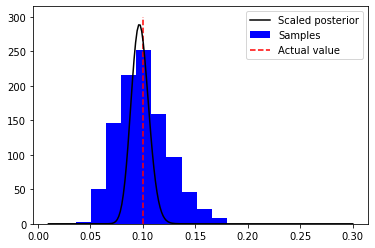

In [9]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Comput KDE

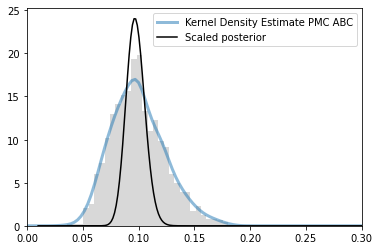

In [11]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [12]:
true_pmc_samples = samples[:, 0]
print(true_pmc_samples)

[0.13483937 0.06944909 0.13676759 0.15279609 0.08982677 0.16879974
 0.09951806 0.09412909 0.11833373 0.12037775 0.15355311 0.09046752
 0.08693453 0.10731102 0.13051183 0.08127951 0.15050703 0.08652541
 0.09296141 0.13979808 0.09486236 0.0971014  0.12133723 0.10604816
 0.08200857 0.13481587 0.15924984 0.08243267 0.15293088 0.12814093
 0.07466803 0.10486608 0.08529969 0.14193043 0.12815445 0.07848743
 0.07200675 0.09048088 0.0593402  0.12453459 0.11240901 0.07895269
 0.11384015 0.17131862 0.06698876 0.15453346 0.10298162 0.12748119
 0.09580494 0.0721323  0.08325862 0.1097412  0.12163716 0.15217437
 0.11498349 0.06714661 0.0940738  0.10019471 0.13895821 0.12559765
 0.089281   0.1087544  0.11184234 0.11674313 0.11315508 0.13766795
 0.11819898 0.1226559  0.15339671 0.07323743 0.0860173  0.10093055
 0.07578074 0.14308813 0.07550207 0.12115882 0.0856314  0.13724077
 0.16614089 0.11479523 0.10433545 0.06925748 0.09330803 0.08416244
 0.09000958 0.08659663 0.0775645  0.1217464  0.12429618 0.1003

In [8]:
some_str = "0.13483937 0.06944909 0.13676759 0.15279609 0.08982677 0.16879974 0.09951806 0.09412909 0.11833373 0.12037775 0.15355311 0.09046752 0.08693453 0.10731102 0.13051183 0.08127951 0.15050703 0.08652541 0.09296141 0.13979808 0.09486236 0.0971014  0.12133723 0.10604816 0.08200857 0.13481587 0.15924984 0.08243267 0.15293088 0.12814093 0.07466803 0.10486608 0.08529969 0.14193043 0.12815445 0.07848743 0.07200675 0.09048088 0.0593402  0.12453459 0.11240901 0.07895269 0.11384015 0.17131862 0.06698876 0.15453346 0.10298162 0.12748119 0.09580494 0.0721323  0.08325862 0.1097412  0.12163716 0.15217437 0.11498349 0.06714661 0.0940738  0.10019471 0.13895821 0.12559765 0.089281   0.1087544  0.11184234 0.11674313 0.11315508 0.13766795 0.11819898 0.1226559  0.15339671 0.07323743 0.0860173  0.10093055 0.07578074 0.14308813 0.07550207 0.12115882 0.0856314  0.13724077 0.16614089 0.11479523 0.10433545 0.06925748 0.09330803 0.08416244 0.09000958 0.08659663 0.0775645  0.1217464  0.12429618 0.10038116 0.07516278 0.09467877 0.10711761 0.09666019 0.07520048 0.15265423 0.12293912 0.0511769  0.06782056 0.10582382 0.06612353 0.09563294 0.07596817 0.12641932 0.06885179 0.07484093 0.11805506 0.12212147 0.05366076 0.10102859 0.07216539 0.07740219 0.1017814  0.11025867 0.10237346 0.11924714 0.0914224  0.0981545  0.06499378 0.10655583 0.11617688 0.0657995  0.11384632 0.07844739 0.11660394 0.08176615 0.10795712 0.08102354 0.10402021 0.05031734 0.12263547 0.11278921 0.09239142 0.0871075  0.09754636 0.12747058 0.10545076 0.06778195 0.10060291 0.08227069 0.1180373  0.12507038 0.10500029 0.09746663 0.08351391 0.10026322 0.06272846 0.12167262 0.1473193  0.10106477 0.08999075 0.11639681 0.05048172 0.0757284  0.09065014 0.11747518 0.08740685 0.10309973 0.08409164 0.11374391 0.14482069 0.13115093 0.16045909 0.12026016 0.12838696 0.12739227 0.13555937 0.09467859 0.12256553 0.12218297 0.13017351 0.12950394 0.11311945 0.09991259 0.16401068 0.09169295 0.10247956 0.07780598 0.09399357 0.09243275 0.07157691 0.10970383 0.09577957 0.12164104 0.11015027 0.099974 0.11251434 0.0443572  0.13148308 0.10243491 0.08330601 0.0768386 0.11005292 0.11415883 0.06679982 0.0952077  0.09457413 0.09001641 0.10270314 0.07885444 0.09324266 0.1040043  0.07977154 0.11841427 0.09393092 0.14205683 0.10290164 0.09781561 0.09241626 0.07680938 0.1003776  0.07309351 0.1156034  0.12372775 0.10927788 0.12649721 0.08338221 0.13696551 0.08182387 0.10003099 0.10129311 0.08679196 0.08156674 0.14562173 0.10909644 0.08764342 0.09329201 0.08778577 0.08604942 0.07314911 0.11353106 0.07829427 0.09752975 0.11156975 0.09014321 0.1149586  0.10596634 0.09702539 0.07839823 0.06130704 0.08644557 0.10559088 0.09687398 0.07238988 0.0776347  0.09268105 0.09012735 0.12157191 0.10437562 0.08207599 0.12501085 0.1229446 0.07394343 0.07746611 0.08083755 0.06450108 0.1579786  0.10911884 0.12648471 0.09904998 0.10620295 0.08609147 0.09131255 0.09130171 0.08968202 0.06863209 0.08126944 0.09865307 0.09751582 0.09887051 0.13561347 0.12193756 0.10794843 0.12092052 0.16195974 0.07727667 0.08965455 0.10187639 0.10292624 0.11596359 0.06690826 0.15103804 0.09789598 0.08904495 0.05489066 0.09972013 0.06969632 0.12847069 0.09620446 0.12771051 0.0864434  0.14054274 0.11896849 0.09698384 0.09377662 0.09027892 0.1130952  0.07497357 0.08872931 0.12043341 0.06439231 0.07780316 0.09821874 0.07887285 0.13958137 0.07046478 0.09498756 0.12201863 0.13435928 0.115635   0.08118171 0.07503337 0.06798326 0.05867529 0.05779482 0.10071019 0.11824661 0.12968419 0.11454414 0.05323203 0.10426657 0.08096706 0.12577155 0.11808173 0.09788275 0.10954856 0.09603443 0.0960635  0.06212821 0.0885003 0.07443468 0.05214052 0.1103487  0.14811139 0.06520598 0.07152229 0.07127079 0.10317662 0.11219852 0.10277088 0.08852326 0.09146821 0.14478057 0.1634483  0.08530106 0.11619557 0.12075534 0.09994057 0.10358932 0.09708745 0.07532895 0.0684791  0.12294459 0.10524305 0.09966669 0.09858633 0.11879255 0.13809715 0.08320775 0.14260738 0.11716512 0.12882779 0.08698713 0.10533987 0.08338811 0.12519954 0.07449616 0.11613604 0.10008803 0.09694157 0.06296121 0.06748478 0.11509851 0.10391405 0.08849818 0.10001277 0.12122889 0.07850066 0.13263785 0.08081191 0.09235615 0.14401345 0.1096816  0.06780037 0.0707258  0.14951485 0.11024924 0.11585461 0.06251176 0.10307547 0.10134524 0.12329773 0.10731353 0.10112725 0.09283608 0.09736311 0.08649331 0.0851796  0.08430141 0.09439721 0.09632988 0.10270244 0.08803264 0.16087584 0.10689327 0.10596617 0.09719873 0.10814555 0.09464429 0.08015232 0.10307376 0.1198648  0.09209872 0.09828247 0.1112673  0.07530428 0.10259788 0.09687332 0.12821574 0.09990465 0.10524219 0.07821027 0.07312569 0.11068752 0.09355501 0.07959322 0.06763934 0.13379137 0.12891321 0.0899088  0.12062099 0.09948604 0.12178855 0.07534407 0.08230084 0.10093887 0.06202156 0.11850696 0.0963249  0.12375308 0.08689442 0.12034548 0.10861549 0.12900677 0.11491086 0.11298501 0.13504879 0.06784576 0.15442359 0.05819357 0.1173736  0.13371885 0.11707508 0.08451463 0.09957924 0.10083218 0.08219375 0.12844246 0.06945623 0.12174668 0.09376218 0.12272362 0.12446147 0.0848466  0.0889135  0.13115396 0.11206054 0.08157059 0.13608778 0.07870391 0.10966497 0.06126113 0.08116213 0.08213359 0.09202089 0.09974821 0.17061715 0.09443336 0.09442686 0.08899971 0.12251616 0.1029293  0.107198   0.09204997 0.10599219 0.0953862 0.0779682  0.10658994 0.11867619 0.13531207 0.08459306 0.05934953 0.06796651 0.09039862 0.08118161 0.09706748 0.08908557 0.08384132 0.10562388 0.11656081 0.11667663 0.12193848 0.06350358 0.10725623 0.11403273 0.12381749 0.10122439 0.12013037 0.06849107 0.09228482 0.08584714 0.08464174 0.07639393 0.11636093 0.11495298 0.08925123 0.10572873 0.11594597 0.08761099 0.08572215 0.0900093  0.0820348 0.0637541  0.0665471  0.13504707 0.06010564 0.13475271 0.10244161 0.16043108 0.07363615 0.13446341 0.14033328 0.10459848 0.1449722 0.06829924 0.07884182 0.11526225 0.086412   0.12225955 0.12272647 0.07598207 0.07015752 0.08065012 0.12563917 0.10404968 0.1257169 0.1436341  0.1014794  0.11206639 0.11644304 0.1310797  0.10387008 0.10826476 0.06561794 0.09318699 0.07143575 0.06094481 0.10242218 0.08634558 0.09272665 0.09100941 0.10174133 0.10652976 0.11338586 0.15687279 0.11676858 0.09567612 0.10115645 0.05568115 0.08271552 0.11409991 0.13138897 0.09321148 0.09348886 0.07058824 0.09512484 0.10094511 0.10782085 0.0953984  0.10177777 0.08264785 0.13569937 0.08970176 0.07816156 0.09294358 0.14901797 0.0707529  0.09917342 0.0971096  0.08838313 0.08043613 0.07963372 0.07173878 0.10881159 0.11338333 0.1319194  0.10120161 0.07314586 0.14936302 0.14381594 0.11100699 0.07708718 0.11110133 0.13788285 0.1095425  0.11192231 0.05868956 0.13330511 0.09199588 0.10951383 0.12904108 0.11612571 0.08381495 0.06086696 0.10510441 0.09676297 0.1096     0.07029044 0.07984387 0.1035622  0.1195173  0.07444266 0.10420546 0.07818047 0.1192568  0.14469006 0.10085189 0.14318803 0.08667618 0.07427024 0.11001304 0.10204702 0.06467594 0.09455426 0.13295164 0.09409242 0.10128493 0.08817932 0.09749278 0.10127947 0.12266825 0.08524618 0.07222683 0.12468203 0.08346799 0.10079665 0.07691104 0.1247397 0.07049279 0.11709189 0.06748143 0.09622188 0.17470015 0.07992741 0.12482287 0.10803287 0.12705285 0.07447777 0.13509552 0.08877809 0.15255143 0.09854038 0.08369704 0.09135671 0.11472811 0.06896219 0.074417   0.11672705 0.11161282 0.13730513 0.13048941 0.09239761 0.09146305 0.09998256 0.08041431 0.09746384 0.08267259 0.10251867 0.08934638 0.09004954 0.11103701 0.06959454 0.07850272 0.06349064 0.1032751  0.08583631 0.09144056 0.08356459 0.07945606 0.09768403 0.0955445  0.13913375 0.08428084 0.07618474 0.09279    0.09751472 0.1008462  0.12463596 0.08440376 0.10643456 0.07095681 0.09893287 0.09939064 0.12372431 0.11005909 0.09911557 0.08108127 0.06318696 0.09409525 0.10007704 0.07396367 0.10457766 0.10406175 0.09243674 0.08138139 0.08530576 0.07642346 0.0811175  0.18009021 0.08848591 0.06394288 0.17934008 0.16548522 0.11923243 0.09901798 0.12636151 0.10325002 0.07798001 0.1149101  0.07865698 0.08706318 0.0697032 0.07226612 0.08230312 0.09403552 0.07739942 0.07959032 0.08167666 0.08971362 0.09790612 0.09994481 0.10698931 0.11764201 0.09540044 0.12424332 0.08019496 0.09494784 0.10879004 0.11408831 0.10264764 0.09657731 0.13621684 0.1311135  0.09114143 0.09448429 0.10567931 0.13777035 0.09847473 0.10037064 0.03601225 0.13324342 0.11518787 0.11751585 0.0705684  0.09398733 0.10034614 0.13769593 0.08938522 0.08771854 0.09825212 0.16622113 0.08446972 0.08275555 0.06207712 0.1131173  0.09807114 0.06455496 0.09960307 0.14099908 0.08001786 0.09443199 0.0831209  0.08039055 0.05103787 0.13828255 0.08991924 0.08369863 0.05869669 0.08442455 0.12825584 0.10176491 0.07089406 0.14613153 0.10238853 0.12963109 0.06585691 0.07196678 0.10895065 0.09903032 0.13568796 0.08742342 0.10161851 0.0640011  0.06482121 0.11235537 0.06312205 0.09856716 0.1133174  0.11368893 0.07008532 0.10650299 0.06644322 0.07358346 0.10483415 0.05778005 0.09823079 0.08132461 0.14491968 0.10543813 0.07733183 0.09840307 0.11051411 0.09262106 0.10890761 0.08067254 0.08413044 0.09537791 0.1408317 0.09694467 0.10941016 0.12378916 0.12472007 0.11391962 0.09037303 0.0894564  0.07091762 0.11106431 0.08942121 0.08480675 0.08396616 0.06452989 0.13885545 0.09637795 0.08551221 0.08674597 0.06721327 0.10531492 0.17045392 0.07479494 0.10433203 0.07550506 0.12292356 0.11986025 0.11172465 0.09209914 0.07852582 0.10539653 0.0826075 0.10432349 0.09306779 0.10011891 0.14892291 0.09924277 0.07068142 0.12170749 0.08457922 0.09792786 0.14229325 0.07286381 0.13757118 0.09705453 0.10758574 0.05433115 0.12443289 0.12470769 0.05396154 0.10513021 0.08582644 0.08826914 0.10013248 0.08835567 0.06966655 0.09633946 0.08873091 0.06861269 0.07133271 0.10219337 0.12507034 0.1018817  0.06362031 0.09097279 0.08958911 0.12443269 0.11650161 0.14398061 0.11767138 0.08040519 0.11860425 0.10688411 0.08542217 0.10067609 0.0598739  0.13466548 0.07372304 0.12399947 0.09651185 0.1198583  0.09172912 0.07850568 0.10520834 0.08940955 0.11385255 0.10349707 0.05747371 0.1289832  0.07878173 0.11937946 0.06566713 0.08394333 0.09551732 0.07489867 0.07129527 0.09624149 0.11596076 0.11040894 0.09863201 0.06246232 0.0939328  0.0975295  0.09233812 0.10698755 0.10873916 0.08108398 0.05178042 0.08120147 0.07465705 0.09738559 0.13279645 0.08276208 0.07569391 0.10153283 0.09942422 0.14584544 0.11022826 0.12719636 0.09890391 0.09562697 0.10774077 0.11456795 0.06609028 0.06446285 0.08838369 0.09580455 0.08788646 0.1084122  0.1064838  0.07256124 0.0735874  0.15406871 0.10665657 0.09637522 0.0903407  0.10833747 0.08465321 0.09511834 0.07705458 0.09431148 0.10998185 0.07753869 0.07814279 0.07188925 0.08734439 0.08830389 0.09426153 0.05662931 0.09125701 0.1180511  0.07011655 0.11632144 0.14543342 0.0813734  0.09359445 0.06188086 0.09783126 0.10130526 0.07014268 0.09599984 0.15178949 0.08015426 0.0882066 0.08880231 0.10303062 0.0841505  0.06342665 0.0848591  0.08738734 0.07044658 0.09379599 0.1125753  0.08772384"


In [9]:
lmao = [ch for ch in some_str]

saved = list(filter(None, some_str.split(' ')))

result = [float(s) for s in saved]

true_pmc_samples = result

# ABC SMC

In [13]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([0.9, 0.8, 0.7]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=0.8
Trying t=2, threshold=0.7
Iter. Eval. Acceptance rate Time m:s
1     51648  1.9361834e-05    0:27.4
2     51651  3.87214188e-05   0:27.4
3     51717  5.80080051e-05   0:27.4
20    62259  0.000321238696   0:35.9
40    74313  0.00053826383    0:43.8
60    85712  0.000700018667   0:51.3
80    95452  0.000838117588   0:57.2
100   111562  0.000896362561   1:06.5
120   117902  0.00101779444    1:09.9
140   130093  0.00107615321    1:16.3
160   142018  0.00112661775    1:22.7
180   155562  0.00115709492    1:29.9
200   165700  0.0012070006     1:35.5
220   175339  0.0012547123     1:40.8
240   184885  0.00129810423    1:46.0
260   196510  0.00132308788    1:52.2
280   211841  0.00132174603    2:00.3
300   222159  0.00135038418    2:06.9
320   235376  0.00135952688    2:14.7
340   247260  0.00137507078    2:21.0
360   255997  0.00140626648    2:25.6
380   267954  0.00141815386    2:31.9
400   283026  0.00141329772    2:39.9
42

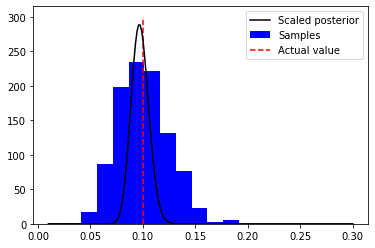

In [15]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=300, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

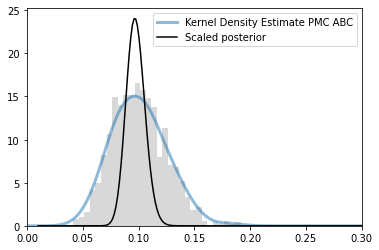

In [16]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [17]:
pmc_fake_samples = samples[:, 0]
print(pmc_fake_samples)

[0.10107164 0.11288636 0.07236055 0.06431273 0.08698871 0.09234446
 0.10085307 0.10407369 0.09920432 0.1094827  0.11084937 0.10077363
 0.12650915 0.07421346 0.12835746 0.12604512 0.0829669  0.05528263
 0.08491751 0.06526128 0.08515942 0.08862808 0.11448484 0.12883448
 0.12531988 0.12213006 0.12214313 0.08636    0.10002606 0.08741427
 0.09294142 0.1234703  0.12740868 0.10601722 0.08188376 0.13647165
 0.10081018 0.09332732 0.09288564 0.09244748 0.08787108 0.07981085
 0.1228482  0.13194194 0.12266544 0.06907743 0.10921927 0.12722043
 0.1031403  0.07533078 0.10519619 0.10103704 0.10326417 0.12556203
 0.08902892 0.10823901 0.07744848 0.09103697 0.12899555 0.08875035
 0.11103464 0.12998517 0.13065204 0.08407433 0.06819056 0.13918387
 0.09958318 0.10736903 0.107777   0.08401324 0.08831588 0.09622122
 0.06062578 0.08821703 0.13387058 0.12057147 0.07658911 0.08482433
 0.08945238 0.1130154  0.09944088 0.09761936 0.07025113 0.09036566
 0.11236135 0.0770997  0.11423499 0.11514078 0.07391843 0.0753

In [10]:
some_str = "0.10107164 0.11288636 0.07236055 0.06431273 0.08698871 0.09234446 0.10085307 0.10407369 0.09920432 0.1094827  0.11084937 0.10077363 0.12650915 0.07421346 0.12835746 0.12604512 0.0829669  0.05528263 0.08491751 0.06526128 0.08515942 0.08862808 0.11448484 0.12883448 0.12531988 0.12213006 0.12214313 0.08636    0.10002606 0.08741427 0.09294142 0.1234703  0.12740868 0.10601722 0.08188376 0.13647165 0.10081018 0.09332732 0.09288564 0.09244748 0.08787108 0.07981085 0.1228482  0.13194194 0.12266544 0.06907743 0.10921927 0.12722043 0.1031403  0.07533078 0.10519619 0.10103704 0.10326417 0.12556203 0.08902892 0.10823901 0.07744848 0.09103697 0.12899555 0.08875035 0.11103464 0.12998517 0.13065204 0.08407433 0.06819056 0.13918387 0.09958318 0.10736903 0.107777   0.08401324 0.08831588 0.09622122 0.06062578 0.08821703 0.13387058 0.12057147 0.07658911 0.08482433 0.08945238 0.1130154  0.09944088 0.09761936 0.07025113 0.09036566 0.11236135 0.0770997  0.11423499 0.11514078 0.07391843 0.07533983 0.12860845 0.07833485 0.10605718 0.09651266 0.10006323 0.11957136 0.10386005 0.11669995 0.07043866 0.04878633 0.11107715 0.12155235 0.09655588 0.09784068 0.1027087  0.09043912 0.06659394 0.09624102 0.12603553 0.09203523 0.09200537 0.11588273 0.12185717 0.11296645 0.08136929 0.0761327  0.10552387 0.12481924 0.09188685 0.12882682 0.12469362 0.13606153 0.08413228 0.10230017 0.08130279 0.06822452 0.07892683 0.06907045 0.11001507 0.09467458 0.08311334 0.09228891 0.12597358 0.08529775 0.07124045 0.08628725 0.1177824  0.09374764 0.12009771 0.09574819 0.07361422 0.09884311 0.09340611 0.08979169 0.07957361 0.10206996 0.067949   0.10024156 0.10287682 0.09441672 0.05850034 0.1107656  0.11256103 0.08659436 0.09229684 0.14367127 0.10452422 0.08425524 0.1009939  0.09113433 0.09982439 0.10781561 0.09278451 0.07898855 0.09996423 0.07848182 0.07485275 0.1148371 0.07390596 0.12592899 0.08375935 0.10775379 0.07493868 0.07607023 0.10814686 0.11305891 0.10549328 0.10026648 0.04136495 0.09633866 0.09146294 0.08846857 0.13180152 0.07981336 0.08434389 0.07590211 0.11080932 0.08098274 0.1148748  0.11592965 0.05791727 0.09618919 0.08159079 0.10214787 0.11302875 0.14016822 0.1106638  0.11456086 0.11563016 0.08463518 0.10994015 0.12299494 0.14126564 0.09590019 0.10474516 0.09819285 0.08897519 0.12621635 0.13709063 0.08061794 0.09792597 0.12105481 0.11432964 0.11119551 0.10603489 0.08252522 0.10085272 0.10920767 0.07698715 0.07797121 0.11824301 0.12763998 0.11345353 0.09822766 0.11599863 0.06829449 0.13799708 0.08799988 0.07475234 0.06031195 0.08024008 0.13724378 0.12163656 0.10353671 0.10055393 0.09349145 0.07722205 0.10594447 0.12913132 0.07231344 0.10215538 0.08845607 0.140295   0.09964787 0.14104305 0.09142499 0.08890735 0.12377475 0.13092992 0.07968289 0.09358118 0.0833122 0.10810853 0.08644588 0.10468621 0.08925055 0.11096542 0.08741752 0.0664971  0.07852515 0.09071572 0.0953433  0.12499572 0.17168162 0.131834   0.13681555 0.10922364 0.11946182 0.10309141 0.09051111 0.09458112 0.08608369 0.07386552 0.10752928 0.06281046 0.05643502 0.07816486 0.11305109 0.10124422 0.08916564 0.07961432 0.08112216 0.11621409 0.09200909 0.10374156 0.06083022 0.09342576 0.07508457 0.11352664 0.14988937 0.10028083 0.12141319 0.08068402 0.08073149 0.08853545 0.12568497 0.06873815 0.12245412 0.07661011 0.08339784 0.10587476 0.11502454 0.0661196  0.10155093 0.08666768 0.13950778 0.09502479 0.10756607 0.10503042 0.09451617 0.09371922 0.11136834 0.09906918 0.13311782 0.08683611 0.08915803 0.11443809 0.13884272 0.09341607 0.11013834 0.11040811 0.06747106 0.13602241 0.05181112 0.07792473 0.08300326 0.05997722 0.13978626 0.08769453 0.11480476 0.05652504 0.11673941 0.11229112 0.09496015 0.07848762 0.07324265 0.08442534 0.08576754 0.09375097 0.06752884 0.11004407 0.08587328 0.181468   0.10111345 0.10864744 0.13186363 0.07158899 0.05898656 0.12918398 0.09657601 0.12740069 0.07392757 0.10368079 0.10023553 0.07735271 0.07136276 0.06877903 0.11671807 0.10918488 0.06930838 0.07598117 0.11212439 0.09231836 0.09618583 0.05714933 0.07389677 0.07156903 0.06200916 0.07410355 0.06741419 0.1141217  0.08989258 0.11200209 0.10058257 0.09270966 0.10683299 0.08587804 0.14152667 0.08763593 0.0883862  0.12523481 0.12412765 0.09437881 0.09049523 0.10807994 0.09855061 0.12762263 0.07602847 0.11313949 0.04511365 0.07965612 0.12217788 0.08876543 0.08377426 0.11279512 0.10997198 0.17798014 0.09335617 0.11207103 0.0821077  0.13590424 0.09567409 0.12404909 0.09345145 0.13629695 0.08563562 0.06320156 0.08684152 0.13465695 0.09301696 0.0976119  0.10864347 0.11536821 0.09965547 0.07558795 0.09727802 0.13843665 0.14950917 0.10165344 0.09740343 0.07775527 0.11433559 0.15283032 0.08368202 0.15505623 0.05685841 0.08154077 0.09878211 0.08441757 0.11116758 0.13577757 0.09223965 0.10576934 0.05617844 0.11110334 0.07586192 0.1439365  0.07845436 0.09919995 0.06189931 0.11618743 0.08133089 0.05584321 0.08492854 0.08371741 0.14375197 0.06735846 0.09206693 0.0941683  0.10048633 0.06723402 0.08254305 0.11155663 0.10274599 0.12293034 0.12810372 0.09103698 0.10145222 0.09053344 0.09701404 0.12415695 0.14597829 0.07766325 0.11216292 0.09105418 0.09395118 0.08304785 0.11858347 0.0747159  0.11781081 0.11558593 0.09816744 0.09780097 0.11429599 0.14019582 0.07918287 0.12936738 0.1321127  0.1248153  0.12481402 0.14046531 0.09718438 0.08017525 0.1175197  0.05743395 0.10117232 0.08325525 0.12040559 0.08913388 0.06849699 0.14138425 0.05849833 0.06305189 0.10719002 0.1111146  0.15146908 0.1414224  0.05855356 0.08985271 0.14590154 0.10945469 0.07389353 0.07120345 0.09966331 0.06529069 0.10283923 0.07480789 0.07305188 0.0787478  0.111187 0.10797649 0.06926441 0.09920357 0.11242909 0.08968635 0.15241917 0.09917966 0.11219284 0.11644128 0.05092336 0.13276874 0.05865782 0.08583326 0.12865103 0.04880489 0.13374698 0.10971055 0.09985519 0.07293839 0.09337885 0.12562272 0.10845888 0.11299028 0.09932707 0.0878003  0.08098692 0.09770588 0.10926011 0.08800005 0.09835808 0.10219719 0.13416888 0.1022178  0.0709489  0.10181255 0.06806219 0.10519874 0.07811791 0.08585912 0.08378991 0.09717339 0.07578579 0.13338946 0.11152256 0.07904739 0.06103037 0.15385263 0.11186191 0.09253862 0.1196239  0.06295461 0.11638664 0.10309779 0.11813132 0.11935953 0.09726155 0.09544883 0.07758406 0.10261676 0.12578079 0.14595373 0.11989451 0.08913497 0.04792779 0.08103436 0.09159459 0.09891201 0.13933003 0.12209806 0.08972497 0.08503054 0.0669301 0.09575081 0.07599491 0.11232753 0.07383624 0.12366252 0.07815063 0.07993713 0.14091433 0.08576189 0.14997615 0.04361199 0.12799807 0.0866879  0.07544548 0.08338112 0.10464391 0.12330145 0.0866319 0.10433657 0.12291042 0.17838596 0.11227144 0.10587126 0.10330235 0.0658673  0.09757249 0.11912656 0.11711227 0.10403121 0.08632931 0.13495981 0.11427021 0.05403689 0.08990084 0.10018488 0.06934042 0.10785193 0.12813572 0.14436735 0.13786796 0.06779557 0.05765792 0.1218423  0.08412729 0.14328113 0.13148155 0.1128997  0.15493593 0.11019368 0.09636703 0.13428181 0.07962241 0.13116317 0.1202877 0.05757675 0.06909399 0.1046974  0.096182   0.10707815 0.1567311 0.1296318  0.07414668 0.08650434 0.1355905  0.08668523 0.10937077 0.06633765 0.1020463  0.07787516 0.11436988 0.07569425 0.12412693 0.12446437 0.11706584 0.18727308 0.07205172 0.10978692 0.11224622 0.12966908 0.0809407  0.08815307 0.0781449  0.08132436 0.07361921 0.09268251 0.10340778 0.08785932 0.09270062 0.14234579 0.10022588 0.1475816  0.05937573 0.09134891 0.07984475 0.08966023 0.08793525 0.09165325 0.12472401 0.10630039 0.08551688 0.11247872 0.10388024 0.11397766 0.10887991 0.14527188 0.08821028 0.07761256 0.12048973 0.10833511 0.17097046 0.08336975 0.08619094 0.07175278 0.11457973 0.06711832 0.10613927 0.06866751 0.15819228 0.13056677 0.11583509 0.10880664 0.08822481 0.1177092  0.13142037 0.10938673 0.09937541 0.11171402 0.11683331 0.12413506 0.05617196 0.06570405 0.07970382 0.07532894 0.08833429 0.11080205 0.13279495 0.11629975 0.08829544 0.08826773 0.10206194 0.0791747  0.10197964 0.06324203 0.10253829 0.07698351 0.13244144 0.10988067 0.11445515 0.09022176 0.08613015 0.09263258 0.11387093 0.09839953 0.07783548 0.12908204 0.09367705 0.10986366 0.08895499 0.08117552 0.112639   0.14378379 0.08740917 0.08547889 0.1059193  0.14407213 0.10510933 0.07139891 0.09806337 0.15914679 0.10647005 0.108118   0.06307621 0.08561581 0.14983139 0.09183936 0.10491501 0.14905875 0.12549386 0.05794495 0.12070856 0.11913145 0.09829912 0.07825799 0.10317638 0.07602778 0.06136495 0.10100044 0.12401652 0.10933119 0.12310329 0.11176206 0.14041984 0.09348913 0.05034218 0.16901905 0.12146588 0.07955147 0.06819015 0.15073687 0.1021513  0.13263751 0.11077055 0.10672919 0.04493885 0.14249331 0.12057409 0.09980657 0.07449007 0.0657397  0.09766525 0.10291774 0.08344212 0.12797149 0.08661075 0.0869239  0.11026014 0.09486935 0.08611214 0.12591467 0.11531153 0.12587743 0.11421303 0.05413226 0.0849046  0.06372337 0.10289606 0.10549032 0.09192731 0.08812747 0.09735225 0.14381041 0.08490153 0.10749206 0.12324667 0.12743638 0.12419836 0.10423883 0.08420139 0.07815979 0.09718813 0.07178678 0.10019846 0.07199151 0.11464618 0.11027434 0.09249132 0.11505178 0.1139097  0.07643254 0.07396075 0.10548428 0.09233109 0.10534377 0.11060864 0.10514528 0.09941369 0.12789578 0.12961397 0.09133683 0.12609776 0.08479513 0.0772449  0.12105859 0.09590293 0.11072894 0.08850262 0.06370476 0.06733887 0.11814301 0.07582365 0.15140136 0.13531421 0.10152903 0.10032618 0.09506364 0.11764524 0.13915999 0.15375188 0.13407258 0.08267795 0.11897636 0.12333493 0.08975668 0.1027689  0.09138431 0.11447658 0.07806521 0.09674976 0.10988163 0.07971043 0.11313536 0.08546212 0.08004712 0.093201 0.07761238 0.07559411 0.07764086 0.09530671 0.11648574 0.10484983 0.13539739 0.08958797 0.06883189 0.10146983 0.10813967 0.12766175 0.09592791 0.08069914 0.10495591 0.09543617 0.08376941 0.0896618 0.10025718 0.14052762 0.13336315 0.14703032 0.06871318 0.13991429 0.13121787 0.09601053 0.0817438  0.13295571 0.14544741 0.18532856 0.08497503 0.11106161 0.09863889 0.14274529 0.12218177 0.09330064 0.10138953 0.0692648  0.0782703  0.10387999 0.10419954 0.12143248 0.10929778 0.15560256 0.07389552 0.06628423 0.10247229 0.06707759 0.14006421 0.0743651  0.11872454 0.08273067 0.08255833 0.08631184 0.10300354 0.07857573 0.07472923 0.09300801 0.09980493 0.0802222 0.08305979 0.06223431 0.09021846 0.13634747 0.10124459 0.07988874 0.13393364 0.07642275 0.08226343 0.12879181 0.08487538 0.11788071 0.06900526 0.06433575 0.06936503 0.1237855  0.09905516 0.11397161 0.1198066  0.07818896 0.06319307 0.10994488 0.07740067 0.10629648 0.13173057 0.08399633 0.09158506 0.06478063 0.07418489 0.09850032 0.15377245 0.06177347 0.12112111 0.1164519  0.07750784 0.12296444 0.08669521 0.10724664 0.10515108 0.10089665 0.08448689 0.09607234 0.10039822 0.06661943 0.06869589 0.12257893 0.13509423 0.10250175 0.05171772 0.10889768 0.15576969 0.10194971 0.12850148 0.12626002 0.06344212 0.10853715 0.10228232 0.10304145 0.10065003 0.19148505 0.13227541 0.1112464  0.15489108 0.09662284"

In [11]:
lmao = [ch for ch in some_str]


saved = list(filter(None, some_str.split(' ')))

result = [float(s) for s in saved]

pmc_fake_samples = result

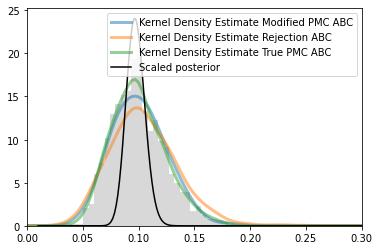

In [94]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = pmc_fake_samples
p_samples = np.array([x for z in rej_abc_samples for y in z for x in y])
r_samples = true_pmc_samples

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# Adaptive PMC ABC

In [5]:
np.random.seed(0)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
cnt_sampled=1000
w_mean=[0.14710439]
resulting var=[[0.01323715]]
cnt_sampled=1100
epsilon=6.352164985262899
w_mean=[0.15211237]
resulting var=[[0.00912145]]
cnt_sampled=1200
epsilon=5.873670062235365
w_mean=[0.14448494]
resulting var=[[0.0099206]]
cnt_sampled=1300
epsilon=5.394441583704471
w_mean=[0.13739819]
resulting var=[[0.00831353]]
cnt_sampled=1400
epsilon=5.034878350069642
w_mean=[0.13484408]
resulting var=[[0.00784302]]
cnt_sampled=1500
epsilon=4.61519230368573
w_mean=[0.12861488]
resulting var=[[0.00723615]]
cnt_sampled=1600
epsilon=4.33589667773576
w_mean=[0.12516825]
resulting var=[[0.00659323]]
cnt_sampled=1700
epsilon=4.049691346263318
w_mean=[0.12311263]
resulting var=[[0.00611713]]
cnt_sampled=1800
epsilon=3.8078865529319543
w_mean=[0.12201673]
resulting var=[[0.00560542]]
cnt_sampled=1900
epsilon=3.6124783736376886
w_mean=[0.11793298]
resulting var=[[0.00502273]]
cnt_sampled=2000
epsilon=3.5071355833500366
w

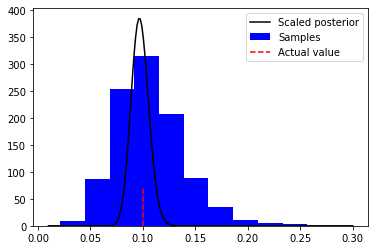

In [6]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=70, label="Actual value", color="red")
mod_true_prob = [x * 8 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

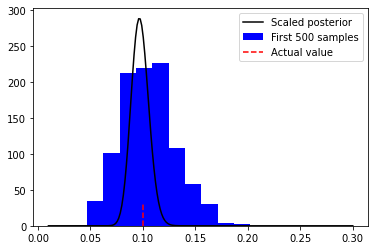

In [37]:
plt.hist(samples[:1000,0], color="blue", label="First 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30, label="Actual value", color="red")
mod_true_prob = [x * 6 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

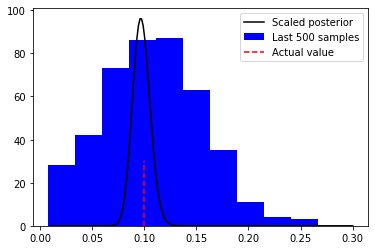

In [41]:
plt.hist(samples[1000:,0], color="blue", label="Last 500 samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=30, label="Actual value", color="red")
mod_true_prob = [x * 2 for x in true_prob]
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
plt.legend()
plt.show()

## Compute KDE

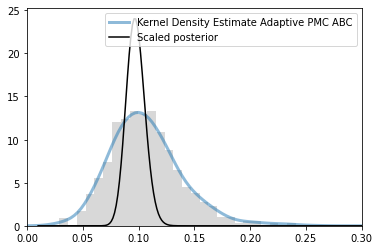

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)

t_samples = np.array([x for x in samples[:1000, 0]])

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

## Save data

In [8]:
adaptive_pmc_samples = samples[:, 0]

In [16]:
adaptive_pmc_samples = samples[:, 0]
print(adaptive_pmc_samples.tolist())

[0.1078523701721358, 0.07598748076193464, 0.058974708504016045, 0.03605896836395067, 0.07961684728183362, 0.08682182788416033, 0.08100239195764945, 0.17284720032535106, 0.08948469778680923, 0.1294255306301922, 0.07136784641235258, 0.06822438839199697, 0.13032498766743622, 0.11332555178774427, 0.08206261044469072, 0.05569078329178566, 0.08328861188841957, 0.08764425803776466, 0.08109837157161438, 0.11214394137976842, 0.13795676512680222, 0.13707342649372975, 0.11953027758590312, 0.10661065454157888, 0.06982323878371706, 0.10816366814576768, 0.10455581084776897, 0.08173106863978875, 0.15071683724677842, 0.11191045916422424, 0.07609275727704683, 0.10454279671004912, 0.2085810017714058, 0.10018946087904275, 0.13207912584884754, 0.0742196266617461, 0.1086567176818168, 0.05717007448202041, 0.06685914540449407, 0.06641893388783167, 0.07951190950934461, 0.059878842636034296, 0.10936338779903598, 0.14879108861204088, 0.08320208139157305, 0.13755095011993348, 0.08822299871494983, 0.1132219717766

In [12]:
adaptive_pmc_samples = [0.1078523701721358, 0.07598748076193464, 0.058974708504016045, 0.03605896836395067, 0.07961684728183362, 0.08682182788416033, 0.08100239195764945, 0.17284720032535106, 0.08948469778680923, 0.1294255306301922, 0.07136784641235258, 0.06822438839199697, 0.13032498766743622, 0.11332555178774427, 0.08206261044469072, 0.05569078329178566, 0.08328861188841957, 0.08764425803776466, 0.08109837157161438, 0.11214394137976842, 0.13795676512680222, 0.13707342649372975, 0.11953027758590312, 0.10661065454157888, 0.06982323878371706, 0.10816366814576768, 0.10455581084776897, 0.08173106863978875, 0.15071683724677842, 0.11191045916422424, 0.07609275727704683, 0.10454279671004912, 0.2085810017714058, 0.10018946087904275, 0.13207912584884754, 0.0742196266617461, 0.1086567176818168, 0.05717007448202041, 0.06685914540449407, 0.06641893388783167, 0.07951190950934461, 0.059878842636034296, 0.10936338779903598, 0.14879108861204088, 0.08320208139157305, 0.13755095011993348, 0.08822299871494983, 0.1132219717766662, 0.0878665695081044, 0.14194289353969328, 0.12291786168922307, 0.10034212244883446, 0.11037524634536201, 0.045280469193312474, 0.09684886126442625, 0.10824113830987626, 0.16460451666143677, 0.13655125718072122, 0.08872757505354201, 0.1548196423005151, 0.11664207796378409, 0.1494323550312253, 0.10151477328772296, 0.09621758089189858, 0.09974494807577514, 0.09207664688213174, 0.12730006476651723, 0.07837252902201465, 0.09221528301448667, 0.09908724356199641, 0.06585083686841445, 0.13586323557891478, 0.09849438328335028, 0.15208257844760598, 0.09247943249174204, 0.061113437854235834, 0.06502175534825813, 0.11262345116918754, 0.14519574238754934, 0.14927710566733673, 0.12253489924365234, 0.08402255761455073, 0.10855067045373552, 0.11251041887287111, 0.11299155137880613, 0.13012054684587043, 0.0628284684000711, 0.06171089459691326, 0.09672608159054799, 0.11352685216521305, 0.1331767364172829, 0.16576567439445744, 0.08990918935753352, 0.04531299761894449, 0.10544441582335294, 0.12970277733795724, 0.11928078082003553, 0.11305733935724678, 0.12810453584723763, 0.12886702174954281, 0.10317868250770834, 0.13512784991401064, 0.10118071262680725, 0.09921947803282602, 0.1651730738236979, 0.09331750626763341, 0.13618015357989038, 0.14839621528447422, 0.08976479167468315, 0.09645700606018524, 0.09254505815755788, 0.10310812196377013, 0.09018441412988884, 0.0798785758769177, 0.08756209209647504, 0.10962205594881971, 0.13404031204629266, 0.16640837581348183, 0.14383480809275362, 0.09459403577002744, 0.1240781725089958, 0.11562153334781027, 0.04788543129886524, 0.09156952728649483, 0.08332724831210936, 0.0867887010916047, 0.1260241810822815, 0.036889529675006555, 0.05222315223680748, 0.10235653028156558, 0.16500014389176357, 0.05393964175539884, 0.08060537911392482, 0.13988573643538094, 0.08577478501998576, 0.08572528767369678, 0.13419501520149388, 0.09175231576507534, 0.16895054467871043, 0.09925211309485545, 0.12001733337752482, 0.06671610526042601, 0.0911646469599777, 0.11904531842141437, 0.07477390551638609, 0.08833107449696703, 0.1095299303345354, 0.10630800098615945, 0.11807062096472584, 0.09222418600238515, 0.06902705637361078, 0.07811402496753703, 0.11578819715616394, 0.12582223965218498, 0.04995257844968781, 0.13612616138194783, 0.06306969972938586, 0.08470950320981084, 0.08390651181000648, 0.06838533717490831, 0.11082429324525159, 0.09918228517084429, 0.0562044565915385, 0.07558184894844729, 0.08287948477123955, 0.07330506980547775, 0.1049079638620674, 0.14849706944394686, 0.12685576609635538, 0.1278304764631279, 0.12543402553217187, 0.10192682808868825, 0.06281247411505117, 0.1112941451385221, 0.12430725321230762, 0.1523142024391081, 0.10414328857215815, 0.0762551493904237, 0.06685255111526854, 0.07699539444049688, 0.0572206491668105, 0.065882295515413, 0.10913384847021801, 0.07805997070674008, 0.14613245120502558, 0.07453556400801681, 0.1001748417027151, 0.12733291328131363, 0.08374452834641351, 0.09745932583284674, 0.09955639464788836, 0.1169474240350217, 0.10816373085548811, 0.06463390782391809, 0.11856872705774447, 0.09582959499346166, 0.10214576594900454, 0.12186273970708636, 0.06469307005581242, 0.08197771170540494, 0.1201926585041741, 0.07838426029875044, 0.1247071844292741, 0.08669742202546936, 0.13787955065121973, 0.08998783320925856, 0.0839577718976797, 0.11404266996978585, 0.05854980502515177, 0.08825454955332625, 0.10105548389712622, 0.10113776762503901, 0.08732044208371688, 0.08612312812968853, 0.1279074349448362, 0.14016411786063812, 0.10066288452697951, 0.1175627542298394, 0.07994007608596473, 0.10248069069532363, 0.05239053773372595, 0.08951399460335223, 0.0990299889787774, 0.06808872904199706, 0.10023334466184963, 0.113840238289297, 0.07885098620517096, 0.12123279493223707, 0.14971502272839388, 0.07218337178589627, 0.14075088436824415, 0.10669253220621847, 0.12157061652644557, 0.11766777547265969, 0.09172378906127904, 0.0886579863187936, 0.06320035564770086, 0.1486682158910785, 0.12177543315192357, 0.1759148408906755, 0.10663015775086404, 0.11121029399005418, 0.0923024787123132, 0.09925792672247918, 0.17000315479987643, 0.09165143304640436, 0.09028327517572404, 0.10847146870496471, 0.12623981075638324, 0.10210903315610788, 0.05550243373171328, 0.06376125862336837, 0.10319588135749401, 0.06766117582080179, 0.15031033802408894, 0.1015936865309706, 0.13662330318083352, 0.13189675411463744, 0.10995343615021198, 0.07722958155053368, 0.1264844096698901, 0.07695624016903377, 0.1329558575718636, 0.17700791776057906, 0.12933154071226705, 0.1056938695676222, 0.09618451722289925, 0.12435705207546278, 0.07819753812512321, 0.10746311995655196, 0.08515582056636493, 0.08000504418721541, 0.09988223616382269, 0.09333876511317764, 0.07310970194102037, 0.09395586377290267, 0.08699999671846559, 0.08751112777218072, 0.1105861877176895, 0.13237057016252926, 0.15904722335239202, 0.10907193963086176, 0.12362168260361087, 0.10855253961869271, 0.08988523328120007, 0.06483518624862773, 0.08096477194885847, 0.1050492525569579, 0.10141339422251727, 0.08758201892139393, 0.12457146335035876, 0.12194472423933835, 0.12284765089908707, 0.12992401835976147, 0.09069581307743499, 0.1609763316347039, 0.07588046452277562, 0.09933823131668768, 0.1650936792744333, 0.1259648737405074, 0.13614386252385857, 0.0662739260120989, 0.06368787529537664, 0.0906726402699626, 0.10861176233094007, 0.10998805231685313, 0.1590109769574258, 0.1430563675430412, 0.10595922700306418, 0.1090589413968427, 0.09151608472849068, 0.08747860308474642, 0.14269835474718057, 0.07806616314206963, 0.12395290990133259, 0.1128595439477932, 0.11366169157427988, 0.15561340014986416, 0.07996674805063497, 0.10849987572472972, 0.12037332638701928, 0.09853508082953205, 0.10802204959478899, 0.1064746038885475, 0.097612889866679, 0.07755449708344145, 0.128477141560214, 0.07511931984380629, 0.17238768529959697, 0.11409541612337677, 0.10774005826661023, 0.1429678891995603, 0.0926096409155831, 0.1449460164062178, 0.09421052605638815, 0.08475526570677161, 0.08318559905626716, 0.08373134541799251, 0.10848316583192383, 0.12112531743392212, 0.06939825709999028, 0.08341421368949178, 0.1222095585122879, 0.0972527927316482, 0.10410549356740546, 0.08780317917787503, 0.12485952904490638, 0.11382073900581506, 0.12791848669787242, 0.11987718899447768, 0.13273543592012715, 0.11211025548670936, 0.11593312473202154, 0.11353299990790358, 0.14504598980596828, 0.10729184826130024, 0.10797778281718655, 0.14557726593619172, 0.10103511861548688, 0.10743912589905061, 0.08214132132493483, 0.10511268491461717, 0.1672360848549705, 0.10244743230209132, 0.14184794005267548, 0.11352492633732121, 0.09356127643372861, 0.12477893879151243, 0.059466734508153624, 0.0957613191905208, 0.10940401100114258, 0.10773733460730456, 0.09558785761883572, 0.08745252523601785, 0.09493648059935483, 0.15779896921136485, 0.1104680879182792, 0.12632846848865698, 0.11549747561923437, 0.1011638079435509, 0.05870449538734496, 0.08254325218061453, 0.10757503362852004, 0.10692352945877119, 0.05550714429630562, 0.06556563275686544, 0.19150300770935152, 0.12766670068565025, 0.09170670140224665, 0.15352855075954086, 0.1543374800197335, 0.09896208503465684, 0.14230888810888637, 0.11380876471281157, 0.055543195592897394, 0.1385022731093749, 0.0611872992408761, 0.09539800211531355, 0.04841929709335565, 0.09234606700258577, 0.09780335035707985, 0.1161544141438446, 0.1513038418158618, 0.070737820980978, 0.11114524678483276, 0.0759636282835695, 0.09185144270621483, 0.08830372578670333, 0.0792251160292436, 0.1102283657974239, 0.10032091682177877, 0.09412311953241793, 0.09240524587677515, 0.12586397467200225, 0.15059302444165576, 0.09303383936237039, 0.08482188624877833, 0.07168347119480165, 0.09070282104945203, 0.06479975406773532, 0.08992654466338812, 0.11709904406066954, 0.07096301444042215, 0.07527014883245955, 0.07953223503200874, 0.11797742322477092, 0.08966033877010444, 0.08391464800363205, 0.15086295311665138, 0.07384062729926824, 0.0954662183319935, 0.09225717970288407, 0.10988348214633817, 0.04844483337894234, 0.12026446877622475, 0.1615962042522975, 0.10400313053304745, 0.1334106034263674, 0.09198226370230511, 0.10230420390518868, 0.07326115611442821, 0.16094941748359304, 0.10094423928687775, 0.11072525166990642, 0.11957214309953564, 0.08215754781921605, 0.12375020207493961, 0.11137014257552603, 0.16550924465541783, 0.07453898636880683, 0.13969162383773653, 0.09636354254185533, 0.1182439818888465, 0.09984000302842791, 0.13382096205542018, 0.08154362656838443, 0.10104080037327809, 0.1348354421415307, 0.11860796976946555, 0.0811898939351151, 0.12110705558298933, 0.12376995516773281, 0.07600069348401024, 0.07191281654139203, 0.08170945001004476, 0.12655856330848667, 0.1003067648233491, 0.07924481139317335, 0.11053776490463588, 0.07881319597481916, 0.07809562372478976, 0.09267551835764434, 0.08353025116675192, 0.09923573077432994, 0.09763919251392975, 0.1034694380000677, 0.08262594833245068, 0.1144673924752945, 0.1316295862488841, 0.10550937843785682, 0.11815418561290009, 0.10932148877229124, 0.11641420652350976, 0.15102232414616187, 0.11950652304150125, 0.06956985429370878, 0.08469167995225571, 0.09820003760263651, 0.16893563718905658, 0.1077733211039871, 0.1399346333538188, 0.12384827940702449, 0.058026405349675306, 0.09654553010502101, 0.09799264872086703, 0.08530859417994476, 0.11470900002304267, 0.081150448551816, 0.10309546449718024, 0.13521931521612504, 0.07446572786579156, 0.05790034565694139, 0.10663941150444649, 0.07904189775234836, 0.14474060577866543, 0.1428575644653111, 0.07068873294875033, 0.09866235026556881, 0.13521095076453982, 0.1100699403388062, 0.12167217878984515, 0.0915855712094652, 0.1569708762099329, 0.14636431572071829, 0.09175261068523291, 0.1029440812441886, 0.0964076384656289, 0.15032422205804652, 0.10074492144641717, 0.16944847367982527, 0.07356496836237872, 0.10292628709780119, 0.09471164212751938, 0.10682861711114693, 0.07759058813972207, 0.123105323790963, 0.12837540691520904, 0.13411737408598357, 0.10920082652267052, 0.0798456698783397, 0.08818574115903267, 0.1347653797063447, 0.10562437793789753, 0.05719427235851228, 0.11619405598941758, 0.10028697248010672, 0.10772061592754709, 0.06516483349549548, 0.11127838037830944, 0.1560970210122367, 0.13709313328176576, 0.12625082298253848, 0.06622398797985779, 0.09695102166156978, 0.11240158211699877, 0.095317099067594, 0.11628305708664577, 0.10652292360907882, 0.1026655510109375, 0.06640429856576353, 0.09393980114964381, 0.11125048249143599, 0.08029382993477849, 0.11890685036927055, 0.09303065537280394, 0.13321267362458572, 0.06659299714925586, 0.12118298663142718, 0.09793245153124798, 0.09047760157463212, 0.05813914756022456, 0.07133652083430578, 0.15940561562379962, 0.06793875718468458, 0.08115316707298945, 0.11250521033731577, 0.13224385136743383, 0.11151683438210591, 0.07971991246250842, 0.11229254217251122, 0.11221322358369645, 0.0809490993488808, 0.08665005623054994, 0.11131995057260649, 0.07119312559343433, 0.07483354046627291, 0.06892471692717576, 0.06485130268223217, 0.12196751719830498, 0.10818546536523023, 0.09187981134185887, 0.07769853088354792, 0.09043772446941066, 0.07838705353239508, 0.0926095120709974, 0.1180015430032943, 0.08404633061663637, 0.12627945928110984, 0.20242754082219944, 0.11275050738077425, 0.11088602454916982, 0.10529123022613558, 0.06645413691801834, 0.10593956527783777, 0.12242770345442794, 0.11117924173798065, 0.09952421860790314, 0.14393558318890165, 0.05022330548982014, 0.07968267780831777, 0.08701830539170749, 0.12046940952854801, 0.10410452127861089, 0.09742320018037905, 0.1321013447187518, 0.12637641122985058, 0.13451896899076604, 0.12108024447941225, 0.10753099690604442, 0.0495666083361572, 0.07931973233167114, 0.10248431331574025, 0.09205658612006007, 0.11804985680083649, 0.08822216374611405, 0.11388295959695366, 0.09916032118993814, 0.10612026242218141, 0.10795012047788632, 0.14837143982221776, 0.08704353589197282, 0.07543222358367603, 0.06907848648927492, 0.06702635653870478, 0.07172139677761342, 0.09929008747410621, 0.11538415576547996, 0.16081360364100775, 0.1291996639959937, 0.103653438468003, 0.0627030666101892, 0.08001721416638499, 0.08603201895228749, 0.09760944221794576, 0.09625876562119022, 0.12394614089634017, 0.09103086672850703, 0.07638542721746781, 0.11083942213825299, 0.0688227409915878, 0.12982137088793566, 0.10867007207223842, 0.10506265385411959, 0.13699614645969285, 0.09872755906639018, 0.1149037649386705, 0.1156964491264831, 0.09945096199608612, 0.0727946200734237, 0.05551307999897571, 0.0547079309196258, 0.1112958901968056, 0.08218261342444022, 0.11101189341814349, 0.11620833734917468, 0.1496407757500578, 0.03459480998165944, 0.08344852322535123, 0.1517670727276989, 0.096354433418307, 0.07757928520724745, 0.09548167838528718, 0.08239563002884637, 0.09072803160293168, 0.15966650104676328, 0.11741942275252154, 0.11218822226796452, 0.13273869365747634, 0.09077980292094466, 0.1446612112277653, 0.07219815621561355, 0.09976260504703073, 0.10558787393175303, 0.16112848161890622, 0.13722793891013804, 0.11986462231210393, 0.1756386232917127, 0.12461604700281166, 0.10048173242314969, 0.06376190916656767, 0.09204403808243945, 0.08876093437707598, 0.07709940311221324, 0.13013285165423313, 0.11620156068192589, 0.12302249411611932, 0.0788565296744135, 0.08363878096209496, 0.13952301274293968, 0.08756862239163202, 0.057560641481515656, 0.12261810071020271, 0.10351429945369131, 0.09079173103739052, 0.0895766002921366, 0.07499375951545044, 0.1364306016242855, 0.09995716995298866, 0.08631371975687138, 0.08759711408689744, 0.08130622079795641, 0.10788172893794479, 0.13304630214272598, 0.09690015623707109, 0.13336255826230575, 0.09524632687416332, 0.11819860852329452, 0.08239478113014169, 0.07998524198403877, 0.07450170448617605, 0.08490768005313548, 0.11854950242206408, 0.08791333931002056, 0.09491058221025322, 0.1560050490512501, 0.08019836761546197, 0.12412384474621131, 0.13831609189922262, 0.10904620113650879, 0.10922726148395885, 0.1184570671328294, 0.16278467508579808, 0.10354559870005592, 0.12831670403093456, 0.08570311787713672, 0.12795113492724947, 0.07273364747748114, 0.10584516838956345, 0.14209173108736997, 0.1227114124823677, 0.09574623452432768, 0.09929588903521283, 0.0903578367196375, 0.07641334472978728, 0.12912292089724958, 0.07850365259949635, 0.14002426345091515, 0.1591001243457854, 0.07694415571205437, 0.1388560126897115, 0.09724475376507745, 0.09249483218848219, 0.10998508361110344, 0.1012824983073839, 0.0984823741308595, 0.11331605659179461, 0.17467229295200637, 0.0540011112524703, 0.08258011044471635, 0.07714874896207664, 0.09540624536586179, 0.06812704243763014, 0.05681068880729798, 0.08104807314456902, 0.11720859939155312, 0.09436543153428997, 0.11571860349685367, 0.060972120921864235, 0.11137431706477494, 0.10547652470241234, 0.09290956001951647, 0.13122973330041782, 0.1020622391766936, 0.0404339266536886, 0.1423831026178926, 0.07248500174650689, 0.09058442479172032, 0.11174035466753651, 0.11059131963343402, 0.13186763742765528, 0.09119179287442458, 0.08089530889738714, 0.10725033952967915, 0.10241787041914824, 0.12261874265489506, 0.15505830901524914, 0.12493285391511191, 0.10225589134553888, 0.07508736485936227, 0.12460907461780629, 0.12440260234014544, 0.09794902810712267, 0.10397040827745799, 0.0760027262103955, 0.09747238989207971, 0.09930318435815257, 0.1969464534472968, 0.11170859864816705, 0.16340636118765786, 0.05954466566895858, 0.14136210545254685, 0.0752716974036799, 0.11216141162882579, 0.13217798207701642, 0.06034505893319412, 0.09233330390946096, 0.07914647378704845, 0.06358411707630084, 0.07234740897494558, 0.11877712133640324, 0.09991409909054569, 0.09108954962641419, 0.18029685757601996, 0.09632674528343846, 0.11176554327680194, 0.13033608924908915, 0.08493807967882086, 0.1249699056214115, 0.12751715855969534, 0.1044701853719133, 0.09049863221099266, 0.10757759403316637, 0.12111101758233855, 0.09465597034179596, 0.0829529624404595, 0.10686057249134874, 0.06911254109246814, 0.11888738295374052, 0.08944541422999326, 0.12135985869854954, 0.14636868971015668, 0.12537232182559627, 0.07594977438772518, 0.0798572059203492, 0.08788445642998786, 0.1681051224897861, 0.05782987019802199, 0.09161279885967549, 0.09113699874998404, 0.06358518621753599, 0.16663391930179322, 0.10242921039517214, 0.10523702750834193, 0.1197804088306465, 0.11725341397071631, 0.1500950207835225, 0.08936387504276269, 0.09505840501521728, 0.06611881462781667, 0.12418366932867528, 0.11331426963007085, 0.11089055382671473, 0.08968875393835551, 0.07378103314148174, 0.09374239763746128, 0.12722944618830143, 0.11568815682569918, 0.09417123723337119, 0.11440411175088465, 0.13813951958658277, 0.10428546387603385, 0.09064964328965283, 0.1319148878073035, 0.12940764624400725, 0.07476644223150457, 0.10228248703647991, 0.10124209082896657, 0.08187383078532962, 0.07492317472004487, 0.11809943166761605, 0.061824394440823195, 0.05919427414092358, 0.08767507629886073, 0.12129798064103679, 0.10059260770239731, 0.1418135914696577, 0.10769381502442482, 0.09917683427648277, 0.12983929162058208, 0.08923197105896513, 0.09715856354154681, 0.1012207656959127, 0.11730599784824725, 0.10290875242355113, 0.13263132869103905, 0.06949903162133725, 0.1009281706717292, 0.07042867722531895, 0.07910445096446957, 0.09686236614770183, 0.11893091168531758, 0.09943710771058115, 0.15125499719492788, 0.11752309153881152, 0.1425374600669874, 0.11384283465627462, 0.08405865780080753, 0.12462483504993431, 0.09778709271236588, 0.08471702194892371, 0.12274643073787539, 0.1780499110881967, 0.07784348494523795, 0.06507316339375044, 0.12667453607026266, 0.10045206703617096, 0.15416989131230224, 0.12299972669308443, 0.13393963632236908, 0.09301855960574693, 0.09933902136064646, 0.06252957570381557, 0.09926973405691669, 0.12170293213698939, 0.08213251773869332, 0.1624028957910118, 0.08715739643182044, 0.12059106248543656, 0.15065954413800106, 0.07760798153410357, 0.1212487767202145, 0.09297922606121628, 0.07188695053861294, 0.16088295958557353, 0.11105790865447032, 0.18084344221804605, 0.19652419978841174, 0.1960140236680915, 0.12977145552362562, 0.1894380666979949, 0.20001527089744991, 0.11109090586350241, 0.1613587041165112, 0.12492894054380951, 0.10902089233856206, 0.080370300123094, 0.03279989032746281, 0.1041631373126043, 0.05364651612801584, 0.1786708592071633, 0.0867314140765855, 0.22024710091278835, 0.12166360798030998, 0.08647140069838878, 0.07392205093940699, 0.16079942434802577, 0.09491685107797942, 0.19342294440256927, 0.18112668271240914, 0.04598337004733729, 0.2043546413756508, 0.12916403332955897, 0.14601987256788962, 0.14358274202575091, 0.2117892916584625, 0.1461864340597739, 0.07450599429249666, 0.03327373836710876, 0.0898623972293975, 0.03211498960885695, 0.2367635444792539, 0.059738019707686565, 0.25660825200045645, 0.18269188979073017, 0.08800077830491995, 0.12499483008093576, 0.14085811920460017, 0.1456128792488435, 0.08944055141078822, 0.10142652727065678, 0.07800325530166402, 0.14398734626678972, 0.21830971971260207, 0.0816537359408032, 0.20593611877401546, 0.11067387711012233, 0.07874190022566308, 0.08428032317257914, 0.15259041266952017, 0.17552218704573572, 0.1661698283182144, 0.2218284872630379, 0.11113386660317673, 0.1190788765024441, 0.13557328785667042, 0.1371740655954036, 0.1812459270673829, 0.13476596325295678, 0.02130289770346147, 0.15357589317745007, 0.10515147215360754, 0.2368840204034657, 0.048345200753309, 0.11973192699930371, 0.16612229045475146, 0.22699578753706864, 0.1511577129364137, 0.06907724050398911, 0.09674414408823115, 0.031191038867240672, 0.15546624980495474, 0.11093192623298058, 0.12615260677170662, 0.08837016513325244, 0.08662876518592712, 0.05672187824226311, 0.1794276783210475, 0.1300392811972408, 0.2369725964805937, 0.12580640310074764, 0.18133927121481971, 0.09393896541761151, 0.1492630973435444, 0.15395631463106899, 0.05262739030674166, 0.06437071612217232, 0.09428617932019345, 0.04778568080897677, 0.10244429655960116, 0.12258128494936296, 0.11358794457836091, 0.1208509434343942, 0.08068992181195825]

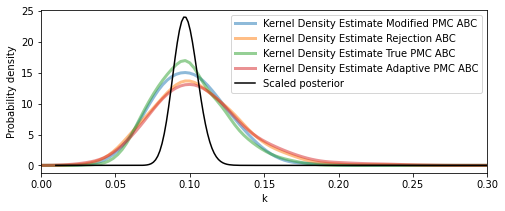

In [14]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 3))

t_samples = np.array(pmc_fake_samples)
p_samples = np.array(rej_abc_samples)
r_samples = np.array(true_pmc_samples)
w_samples = np.array(adaptive_pmc_samples)

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.007),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(w_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
# ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True, label='Samples')
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')
plt.xlabel("k")
plt.ylabel("Probability density")

plt.savefig(my_path + '/all_kdes.pdf')

In [66]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

# Hamiltonian ABC SGLD

In [19]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        # vals[i] = the i-th datapoint
        # vals[i][j] = the population at time t[j]
#         print("vals="+str(vals))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
#                 print("t="+str(t_mean[j]))
#                 print("vals="+str(vals[i][j]))
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
#         print("vals="+str(vals))
#         print("t_mean="+str(t_mean))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        

        # t_cov[i] = covariance matrix for time i
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
#             t_cov[i] = np.eye(len(self._y[0]))
#         print("t_cov=")
#         print(t_cov)
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))
#             print("y[i]="+str(self._y[i]))
#             print("mean[i]="+str(t_mean[i]))


        rez = np.log(rez)
        return rez

In [20]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        g = np.zeros(len(theta))
        self._grads = None
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(len(theta))
            for i in range(len(theta)):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
                
            g += (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta 
            
            
            g += aux
        
        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        if len(grad_val.shape) > 1:
            grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [[self._theta0]]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=15, R=2)
                    next_theta = curr_theta + self._eps * np.random.normal(0, np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [21]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.15])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return model.simulate(theta, times)


abc = HABCsgld(1000, theta0, 20, 0.002, 0.1, log_prior, sim_f, 0.001, y)

print("abc started")

results = abc.run()

print("abc finished")
print(results)

abc started
t= 1, curr_theta =[[0.15063451]]
t= 2, curr_theta =[[0.15221195]]
t= 3, curr_theta =[[0.14197324]]
t= 4, curr_theta =[[0.13241595]]
t= 5, curr_theta =[[0.1246818]]
t= 6, curr_theta =[[0.13223168]]
t= 7, curr_theta =[[0.14199327]]
t= 8, curr_theta =[[0.14632115]]
t= 9, curr_theta =[[0.15606223]]
t= 10, curr_theta =[[0.12843323]]
t= 11, curr_theta =[[0.12273197]]
t= 12, curr_theta =[[0.12449283]]
t= 13, curr_theta =[[0.11472854]]
t= 14, curr_theta =[[0.12763931]]
t= 15, curr_theta =[[0.14218596]]
t= 16, curr_theta =[[0.13547726]]
t= 17, curr_theta =[[0.13512609]]
t= 18, curr_theta =[[0.16046347]]
t= 19, curr_theta =[[0.17283815]]
t= 20, curr_theta =[[0.16746781]]
t= 21, curr_theta =[[0.15702203]]
t= 22, curr_theta =[[0.16336468]]
t= 23, curr_theta =[[0.15644479]]
t= 24, curr_theta =[[0.15806408]]
t= 25, curr_theta =[[0.14864382]]
t= 26, curr_theta =[[0.15765519]]
t= 27, curr_theta =[[0.17000067]]
t= 28, curr_theta =[[0.16198665]]
t= 29, curr_theta =[[0.15785409]]
t= 30, curr_

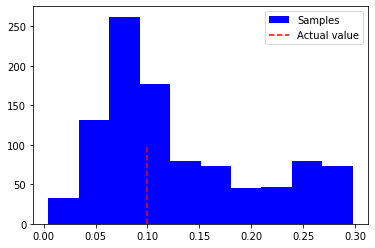

In [22]:
res_f = [ x for sublist in results for x in sublist ]
resff = [ x for sublist in res_f for x in sublist ]


plt.hist(resff, color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=100, label="Actual value", color="red")
plt.legend()
plt.show()

In [43]:
h_samples = resff

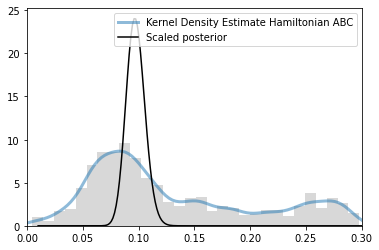

In [48]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True)


x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(np.array(h_samples), x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.hist(h_samples, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

# All errors

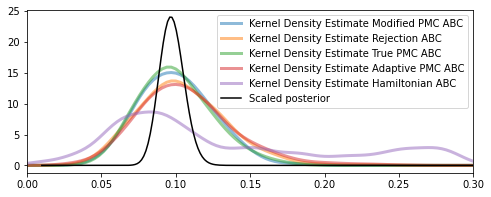

In [53]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

mod_true_prob = [x * 0.5 for x in true_prob]
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 3))

t_samples = np.array(pmc_fake_samples)
p_samples = np.array(rej_abc_samples)
r_samples = np.array(true_pmc_samples)
w_samples = np.array(adaptive_pmc_samples)

# print(p_samples)

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(p_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(r_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate True PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(w_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(h_samples), x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
# ax.hist(samples[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True, label='Samples')
plt.plot(thetas, mod_true_prob, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')

plt.savefig(my_path + '/all_kdes.pdf')

# Compute KL-divergence

In [55]:
def kl_func(y, post, kde_skl):
    part = posterior(values, times, y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div(x, bandwidth, posterior, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func(y, posterior, kde_skl)
    return integrate.quad(fun, 0.01, 0.3)

def s_posterior(theta):
    return posterior(values, times, theta)


t_samples = np.array(pmc_fake_samples)
p_samples = np.array(rej_abc_samples)
r_samples = np.array(true_pmc_samples)
w_samples = np.array(adaptive_pmc_samples)

kl_div_rej = kl_div(p_samples, 0.01, s_posterior)[0]
kl_div_pmc_fake = kl_div(t_samples, 0.01, s_posterior)[0]
kl_div_pmc_true = kl_div(r_samples, 0.01, s_posterior)[0]
kl_div_pmc_adaptive = kl_div(w_samples, 0.01, s_posterior)[0]
kl_div_hamiltonian = kl_div(np.array(h_samples), 0.01, s_posterior)[0]


print("rej = "+ str(kl_div_rej))
print("pmc modified = "+ str(kl_div_pmc_fake))
print("pmc true = "+ str(kl_div_pmc_true))
print("adaptive pmc = "+ str(kl_div_pmc_adaptive))
print("hamiltonian = "+ str(kl_div_hamiltonian))

rej = 0.8108950263232512
pmc modified = 0.7062888228936999
pmc true = 0.6712863117899887
adaptive pmc = 0.8436922904518308
hamiltonian = 1.3775317558441373


# Something something

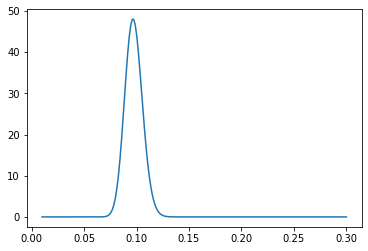

In [43]:
plt.plot(thetas, true_prob)
plt.show()

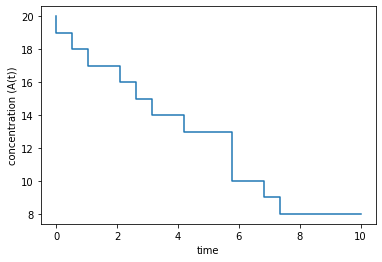

In [47]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

In [57]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        # vals[i] = the i-th datapoint
        # vals[i][j] = the population at time t[j]
#         print("vals="+str(vals))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
#                 print("t="+str(t_mean[j]))
#                 print("vals="+str(vals[i][j]))
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
#         print("vals="+str(vals))
#         print("t_mean="+str(t_mean))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        

        # t_cov[i] = covariance matrix for time i
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
#             t_cov[i] = np.eye(len(self._y[0]))
#         print("t_cov=")
#         print(t_cov)
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))
#             print("y[i]="+str(self._y[i]))
#             print("mean[i]="+str(t_mean[i]))


        rez = np.log(rez)
        return rez

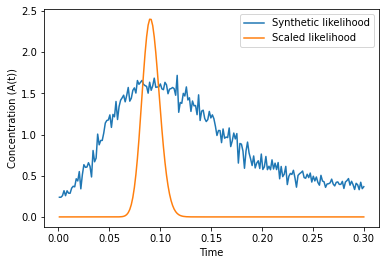

In [70]:
thetas = np.linspace(0.001, 0.3, 200)
# print("VALUES="+str(values))

eps = 0.1

# print(eps)

y = np.array([[x] for x in values])

synt_likelihood = ActuallySyntheticLikelihood(y, eps)
evals = []

def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return model.simulate(theta, times)

for theta in thetas:
    data = None
    rez = 0
    for i in range(0,30):
        new_data = sim_f(np.array([theta]))
        # new_data = [[x] for x in new_data]
        
        if data is None:
            data = [new_data]
        else:
            data.append(new_data)
    rez += synt_likelihood.pdf(data)
#     print("theta="+str(theta)+", rez="+str(rez))
    evals.append(rez)

s_true_prob = []
for val in true_prob:
    s_true_prob.append(val / 20)

plt.plot(thetas, evals, label="Synthetic likelihood")
plt.plot(thetas, s_true_prob, label="Scaled likelihood")
plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')
# plt.show()
plt.legend()
plt.savefig(my_path + './synt_like.pdf')